# Análises de dados dos jogadres e times da MLB (Major League Baseball)

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import dateutil.relativedelta
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
import shap
import scipy.stats as stats 
from scipy.stats import mannwhitneyu, ttest_ind

pd.set_option('display.max_columns',None)
pd.set_option('float_format', '{:f}'.format)

### Base com informações sobre os jogadores

In [2]:
df_players = pd.read_csv('People.csv')

In [3]:
df_players.head(3)

playerID   birthYear  birthMonth  birthDay birthCountry birthState  \
0  aardsda01 1981.000000   12.000000 27.000000          USA         CO   
1  aaronha01 1934.000000    2.000000  5.000000          USA         AL   
2  aaronto01 1939.000000    8.000000  5.000000          USA         AL   

  birthCity   deathYear  deathMonth  deathDay deathCountry deathState  \
0    Denver         NaN         NaN       NaN          NaN        NaN   
1    Mobile 2021.000000    1.000000 22.000000          USA         GA   
2    Mobile 1984.000000    8.000000 16.000000          USA         GA   

  deathCity nameFirst nameLast    nameGiven     weight    height bats throws  \
0       NaN     David  Aardsma  David Allan 215.000000 75.000000    R      R   
1   Atlanta      Hank    Aaron  Henry Louis 180.000000 72.000000    R      R   
2   Atlanta    Tommie    Aaron   Tommie Lee 190.000000 75.000000    R      R   

        debut   finalGame   retroID    bbrefID  
0  2004-04-06  2015-08-23  aardd001  aardsda01  
1  1954-04-13  1976-10-03  aaroh101  aaronha01  
2  1962-04-10  1971-09-26  aarot101  aaronto01

In [4]:
df_players2 = df_players[['playerID','birthYear','birthCountry','nameFirst','nameLast','weight','height','bats',
                          'throws','debut','finalGame']]

df_players2['birthYear'] = df_players2['birthYear'].fillna(-1).astype('int64')
df_players2['name'] = df_players2['nameFirst'] + ' ' + df_players2['nameLast'] ### Primeiro e último nome dos jogadores

df_players2['debut'] = pd.to_datetime(df_players2.debut,format='%Y-%m-%d')
df_players2['finalGame'] = pd.to_datetime(df_players2.finalGame,format='%Y-%m-%d')

df_players2['seasons_played'] = df_players2.finalGame.dt.year-df_players2.debut.dt.year ### Temporadas jogadas na MLB
df_players2['seasons_played'] = df_players2['seasons_played'].fillna(-1).astype('int64')

In [5]:
df_players2.head(3)

playerID  birthYear birthCountry nameFirst nameLast     weight    height  \
0  aardsda01       1981          USA     David  Aardsma 215.000000 75.000000   
1  aaronha01       1934          USA      Hank    Aaron 180.000000 72.000000   
2  aaronto01       1939          USA    Tommie    Aaron 190.000000 75.000000   

  bats throws      debut  finalGame           name  seasons_played  
0    R      R 2004-04-06 2015-08-23  David Aardsma              11  
1    R      R 1954-04-13 1976-10-03     Hank Aaron              22  
2    R      R 1962-04-10 1971-09-26   Tommie Aaron               9

### Base de Arremessadores

In [6]:
df_pitching = pd.read_csv('Pitching.csv')

In [7]:
#df_pitching2 = df_pitching.loc[(df_pitching.yearID>=1960)]

In [8]:
df_pitching.yearID.max()

2021

In [9]:
#df_pitching

### WAR Arremessadores

In [9]:
df_war_pitching = pd.read_csv("https://www.baseball-reference.com/data/war_daily_pitch.txt")

In [279]:
#df_war_pitching.to_csv('war_daily_pitch.csv')

In [10]:
df_war_pitching2 = df_war_pitching[['player_ID','year_ID','team_ID','stint_ID','lg_ID','WAR','age','salary']]

df_war_pitching2.rename(columns={'player_ID':'playerID','year_ID':'yearID','team_ID':'teamID','stint_ID':'stint',
                                 'lg_ID':'lgID','salary':'salary_war','age':'age_war'},inplace=True)

df_pitching2 = df_pitching.merge(df_war_pitching2,on=['playerID','yearID','teamID','stint','lgID'],how='left')

In [11]:
df_pitching3 = df_pitching2.groupby(['playerID','yearID'],as_index=False)\
                         .agg({'G':'sum','W':'sum','L':'sum','GS':'sum','CG':'sum','SHO':'sum','SV':'sum','IPouts':'sum',
                               'H':'sum','ER':'sum','BB':'sum','SO':'sum','IBB':'sum','HBP':'sum','HR':'sum','ERA':'mean',
                               'BAOpp':'mean','WP':'sum','BK':'sum','BFP':'sum','GF':'sum','R':'sum','SH':'sum','SF':'sum',
                               'GIDP':'sum','WAR':'mean','age_war':'max','salary_war':'mean'})

### Definição de arremessador titular (SP) e reserva (RP)
df_pitching3['GS_perc'] = df_pitching3.GS/df_pitching3.G
df_pitching3['pitcher_type'] = np.where(df_pitching3.GS_perc>=0.5,'SP','RP')

### Bases de Rebatedores

In [12]:
df_batting = pd.read_csv('Batting.csv')

In [13]:
df_batting.head(3)

playerID  yearID  stint teamID lgID   G   AB   R   H  2B  3B  HR  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0   0   0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6   0   0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4   5   0   

        RBI       SB       CS  BB       SO  IBB  HBP  SH  SF     GIDP  
0  0.000000 0.000000 0.000000   0 0.000000  NaN  NaN NaN NaN 0.000000  
1 13.000000 8.000000 1.000000   4 0.000000  NaN  NaN NaN NaN 0.000000  
2 19.000000 3.000000 1.000000   2 5.000000  NaN  NaN NaN NaN 1.000000

### WAR Rebatedores

In [14]:
df_war_batting = pd.read_csv("https://www.baseball-reference.com/data/war_daily_bat.txt")

In [15]:
#df_war_batting.to_csv('war_daily_bat.csv')

In [15]:
df_war_batting2 = df_war_batting[['player_ID','year_ID','team_ID','stint_ID','lg_ID','WAR','age','salary']]

df_war_batting2.rename(columns={'player_ID':'playerID','year_ID':'yearID','team_ID':'teamID','stint_ID':'stint',
                                'lg_ID':'lgID','salary':'salary_war','age':'age_war'},inplace=True)

df_batting2 = df_batting.merge(df_war_batting2,on=['playerID','yearID','teamID','stint','lgID'],how='left')

### Junção dos números dos jogadores por temporada, mesmo que ele tenha jogado por dois times distintos

df_batting3 = df_batting2.groupby(['playerID','yearID'],as_index=False)\
                         .agg({'G':'sum','AB':'sum','R':'sum','H':'sum','2B':'sum','3B':'sum','HR':'sum','RBI':'sum',
                               'SB':'sum','CS':'sum','BB':'sum','SO':'sum','IBB':'sum','HBP':'sum','SH':'sum','SF':'sum',
                               'GIDP':'sum','WAR':'mean','age_war':'max','salary_war':'mean'})

In [16]:
df_batting3.head(3)

playerID  yearID   G  AB  R  H  2B  3B  HR      RBI       SB       CS  BB  \
0  aardsda01    2004  11   0  0  0   0   0   0 0.000000 0.000000 0.000000   0   
1  aardsda01    2006  45   2  0  0   0   0   0 0.000000 0.000000 0.000000   0   
2  aardsda01    2007  25   0  0  0   0   0   0 0.000000 0.000000 0.000000   0   

        SO      IBB      HBP       SH       SF     GIDP  WAR  age_war  \
0 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000  NaN      NaN   
1 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000  NaN      NaN   
2 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000  NaN      NaN   

   salary_war  
0         NaN  
1         NaN  
2         NaN

In [17]:
### AVG = average (H/AB)

df_batting3['AVG'] = df_batting3.H/df_batting3.AB

### OBP = on base percentage ((H+BB+HBP)/(AB+BB+HBP+SF)) ---- Percentual de chegadas em base

df_batting3['PA'] = df_batting3.AB+df_batting3.BB+df_batting3.HBP.fillna(0)\
                    +df_batting3.SF.fillna(0)+df_batting3.SH.fillna(0) ### Plate Apperance
df_batting3['OBP'] = (df_batting3.H+df_batting3.BB+df_batting3.HBP.fillna(0))/df_batting3.PA

### SLG = slugging percentage ((1B + 2 × 2B + 3 × 3B + 4 × HR) / AB)

df_batting3['1B'] = df_batting3['H'] - df_batting3['2B'] - df_batting3['3B'] - df_batting3['HR'] ### Singles
df_batting3['TB'] = df_batting3['1B']+(2*df_batting3['2B'])+(3*df_batting3['3B'])+(4*df_batting3['HR']) ### Total Bases
df_batting3['SLG'] = df_batting3['TB']/df_batting3['AB']

### OPS = on base + sluggin ((H+BB+HBP) / (AB+BB+SF+HBP)) + (((1 × B) + (2 × D) + (3 × T) + (4 × HR)) / AB)

df_batting3['OPS'] = df_batting3.OBP+df_batting3.SLG

### Corridas criadas (Fórmula criada por Bill James) ((H+BB+HBP)*TB)/(PA+BB+HBP)

df_batting3['R_create'] = ((df_batting3.H+df_batting3.BB+df_batting3.HBP)*df_batting3.TB)/(df_batting3.PA+df_batting3.BB+df_batting3.HBP)

### Proporção da fórmula de corridas criadas x corriadas realizadas

df_batting3['R_create_x_R'] = (df_batting3.R_create/df_batting3.R)-1

### Percentual de SB bem sucedidos

df_batting3['SB_percentage'] = df_batting3.SB/(df_batting3.SB+df_batting3.CS)

### Corridas para cada rebatida

df_batting3['R_per_H'] = df_batting3.H/df_batting3.R

### Corridas para cada aparição em base (H+BB+HBP)

df_batting3['R_per_BAP'] = (df_batting3.H+df_batting3.BB+df_batting3.HBP)/df_batting3.R

### Corridas para cada roubo de base bem sucedido

df_batting3['R_per_SB'] = df_batting3.SB/df_batting3.R

### Base de Defensores

In [18]:
df_defense = pd.read_csv('Fielding.csv')

In [19]:
df_defense.head(3)

playerID  yearID  stint teamID lgID POS   G        GS    InnOuts  PO   A  \
0  abercda01    1871      1    TRO  NaN  SS   1  1.000000  24.000000   1   3   
1   addybo01    1871      1    RC1  NaN  2B  22 22.000000 606.000000  67  72   
2   addybo01    1871      1    RC1  NaN  SS   3  3.000000  96.000000   8  14   

          E  DP  PB  WP  SB  CS  ZR  
0  2.000000   0 NaN NaN NaN NaN NaN  
1 42.000000   5 NaN NaN NaN NaN NaN  
2  7.000000   0 NaN NaN NaN NaN NaN

In [20]:
df_defense2 = df_defense.groupby(['playerID','yearID','POS'],as_index=False).agg({'G':'sum'})
df_error = df_defense.groupby(['playerID','yearID'],as_index=False).agg({'E':'sum'})
df_defense3 = df_defense2.sort_values(['playerID','yearID','G']).drop_duplicates(['playerID','yearID'],keep='last')
df_defense4 = df_defense3.merge(df_error,on=['playerID','yearID'],how='left').drop(columns=['G'])

### Base com aparições dos jogadores por posição

In [21]:
df_appearances = pd.read_csv('Appearances.csv')

In [22]:
df_appearances.head(3)

yearID teamID lgID   playerID  G_all        GS  G_batting  G_defense  G_p  \
0    1871    TRO  NaN  abercda01      1  1.000000          1   1.000000    0   
1    1871    RC1  NaN   addybo01     25 25.000000         25  25.000000    0   
2    1871    CL1  NaN  allisar01     29 29.000000         29  29.000000    0   

   G_c  G_1b  G_2b  G_3b  G_ss  G_lf  G_cf  G_rf  G_of     G_dh     G_ph  \
0    0     0     0     0     1     0     0     0     0 0.000000 0.000000   
1    0     0    22     0     3     0     0     0     0 0.000000 0.000000   
2    0     0     2     0     0     0    29     0    29 0.000000 0.000000   

      G_pr  
0 0.000000  
1 0.000000  
2 0.000000

In [23]:
df_appearances['POS_OFENSE'] = np.where(df_appearances.G_dh/df_appearances.G_batting>=0.5,'DH',np.nan)

### Base dos Times

In [24]:
df_teams = pd.read_csv('Teams.csv')

In [25]:
df_teams.head(1)

yearID lgID teamID franchID divID  Rank   G  Ghome   W   L DivWin WCWin  \
0    1871  NaN    BS1      BNA   NaN     3  31    NaN  20  10    NaN   NaN   

  LgWin WSWin    R    AB    H  2B  3B  HR        BB        SO        SB  \
0     N   NaN  401  1372  426  70  37   3 60.000000 19.000000 73.000000   

         CS  HBP  SF   RA   ER      ERA  CG  SHO  SV  IPouts   HA  HRA  BBA  \
0 16.000000  NaN NaN  303  109 3.550000  22    1   3     828  367    2   42   

   SOA    E  DP       FP                  name                 park  \
0   23  243  24 0.834000  Boston Red Stockings  South End Grounds I   

   attendance  BPF  PPF teamIDBR teamIDlahman45 teamIDretro  
0         NaN  103   98      BOS            BS1         BS1

In [26]:
### Saldo de corridas

df_teams['saldo_corridas'] = df_teams.R-df_teams.RA ### Saldo de corridas anotadas x corridas cedidas
df_teams['saldo_corridas_creditadas'] = df_teams.R-df_teams.ER ### Saldo de corridas anotadas x corridas cedidas creditadas

### AVG = average (H/AB)

df_teams['AVG'] = df_teams.H/df_teams.AB

### OBP = on base percentage ((H+BB+HBP)/(AB+BB+HBP+SF)) ---- Percentual de chegadas em base

df_teams['PA'] = df_teams.AB+df_teams.BB+df_teams.HBP.fillna(0)+df_teams.SF.fillna(0) ### Plate Apperance
df_teams['OBP'] = (df_teams.H+df_teams.BB+df_teams.HBP.fillna(0))/df_teams.PA

### SLG = slugging percentage ((1B + 2 × 2B + 3 × 3B + 4 × HR) / AB)

df_teams['1B'] = df_teams['H'] - df_teams['2B'] - df_teams['3B'] - df_teams['HR'] ### Singles
df_teams['TB'] = df_teams['1B']+(2*df_teams['2B'])+(3*df_teams['3B'])+(4*df_teams['HR']) ### Total Bases
df_teams['SLG'] = df_teams['TB']/df_teams['AB']

### OPS = on base + sluggin ((H+BB+HBP) / (AB+BB+SF+HBP)) + (((1 × B) + (2 × D) + (3 × T) + (4 × HR)) / AB)

df_teams['OPS'] = df_teams.OBP+df_teams.SLG

### Corridas criadas (Fórmula criada por Bill James) ((H+BB+HBP)*TB)/(PA+BB+HBP)

df_teams['R_create'] = ((df_teams.H+df_teams.BB+df_teams.HBP)*df_teams.TB)/(df_teams.PA+df_teams.BB+df_teams.HBP)

### Proporção da fórmula de corridas criadas x corriadas realizadas

df_teams['R_create_x_R'] = (df_teams.R_create/df_teams.R)-1

### Percentual de SB bem sucedidos

df_teams['SB_percentage'] = df_teams.SB/(df_teams.SB+df_teams.CS)

### Corridas para cada rebatida

df_teams['R_per_H'] = df_teams.H/df_teams.R

### Corridas para cada aparição em base (H+BB+HBP)

df_teams['R_per_BAP'] = (df_teams.H+df_teams.BB+df_teams.HBP)/df_teams.R

### Corridas para cada roubo de base bem sucedido

df_teams['R_per_SB'] = df_teams.SB/df_teams.R

In [27]:
df_teams.tail(3)

yearID lgID teamID franchID divID  Rank    G     Ghome   W    L DivWin  \
2982    2021   AL    TEX      TEX     W     5  162 81.000000  60  102      N   
2983    2021   AL    TOR      TOR     E     4  162 80.000000  91   71      N   
2984    2021   NL    WAS      WSN     E     5  162 81.000000  65   97      N   

     WCWin LgWin WSWin    R    AB     H   2B  3B   HR         BB          SO  \
2982     N     N     N  625  5405  1254  225  24  167 433.000000 1381.000000   
2983     N     N     N  846  5476  1455  285  13  262 496.000000 1218.000000   
2984     N     N     N  724  5385  1388  272  20  182 573.000000 1303.000000   

             SB        CS       HBP        SF   RA   ER      ERA  CG  SHO  SV  \
2982 106.000000 29.000000 58.000000 31.000000  815  758 4.790000   0    3  31   
2983  81.000000 20.000000 51.000000 35.000000  663  610 3.910000   1   14  34   
2984  56.000000 26.000000 84.000000 31.000000  820  743 4.800000   1    8  36   

      IPouts    HA  HRA  BBA   SOA   E   DP       FP                  name  \
2982    4273  1402  232  513  1239  83  146 0.986000         Texas Rangers   
2983    4216  1257  209  473  1468  90  122 0.984000     Toronto Blue Jays   
2984    4183  1364  247  548  1346  96  116 0.983000  Washington Nationals   

                  park     attendance  BPF  PPF teamIDBR teamIDlahman45  \
2982  Globe Life Field 2110258.000000   99  101      TEX            TEX   
2983      Sahlen Field  805901.000000  102  101      TOR            TOR   
2984    Nationals Park 1465543.000000   95   96      WSN            MON   

     teamIDretro  saldo_corridas  saldo_corridas_creditadas      AVG  \
2982         TEX            -190                       -133 0.232007   
2983         TOR             183                        236 0.265705   
2984         WAS             -96                        -19 0.257753   

              PA      OBP   1B    TB      SLG      OPS   R_create  \
2982 5927.000000 0.294415  838  2028 0.375208 0.669624 551.396074   
2983 6058.000000 0.330472  895  2552 0.466034 0.796506 773.520666   
2984 6073.000000 0.336736  914  2246 0.417084 0.753821 682.476969   

      R_create_x_R  SB_percentage  R_per_H  R_per_BAP  R_per_SB  
2982     -0.117766       0.785185 2.006400   2.792000  0.169600  
2983     -0.085673       0.801980 1.719858   2.366430  0.095745  
2984     -0.057352       0.682927 1.917127   2.824586  0.077348

### Base dos Técnicos

In [28]:
df_managers = pd.read_csv('Managers.csv')

In [29]:
df_managers.head(3)

playerID  yearID teamID lgID  inseason   G   W   L  rank plyrMgr
0  wrighha01    1871    BS1  NaN         1  31  20  10     3       Y
1   woodji01    1871    CH1  NaN         1  28  19   9     2       Y
2  paborch01    1871    CL1  NaN         1  29  10  19     8       Y

### Estádios

In [30]:
df_parks = pd.read_csv('Parks.csv')

In [31]:
df_parks.head(3)

park.key                 park.name                     park.alias     city  \
0    ALB01            Riverside Park                            NaN   Albany   
1    ALT01             Columbia Park                            NaN  Altoona   
2    ANA01  Angel Stadium of Anaheim  Edison Field; Anaheim Stadium  Anaheim   

  state country  
0    NY      US  
1    PA      US  
2    CA      US

### Salários

In [32]:
df_salaries = pd.read_csv('Salaries.csv')

In [33]:
df_salaries.head(3)

yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000

In [34]:
df_salaries.yearID.max()

2016

In [35]:
df_salaries2 = df_salaries.groupby(['playerID','yearID'],as_index=False).mean()

In [36]:
df_salaries2.loc[(df_salaries2.yearID == df_salaries2.yearID.max())].describe()

yearID          salary
count  852.000000      852.000000
mean  2016.000000  4400950.870892
std      0.000000  5902009.639460
min   2016.000000   507500.000000
25%   2016.000000   520000.000000
50%   2016.000000  1500000.000000
75%   2016.000000  6000000.000000
max   2016.000000 33000000.000000

### Local onde os jogadores se formaram na faculdade

In [37]:
df_college = pd.read_csv('CollegePlaying.csv')

In [38]:
df_college.head(3)

playerID schoolID  yearID
0  aardsda01   pennst    2001
1  aardsda01     rice    2002
2  aardsda01     rice    2003

In [39]:
### Filtrando apenas o último ano de cada jogador na faculdade

df_college2 = df_college.sort_values(['playerID','yearID']).drop_duplicates(['playerID'],keep='last')

### Hall of Fame

In [40]:
df_hof = pd.read_csv('HallOfFame.csv')

In [41]:
df_hof2 = df_hof.loc[(df_hof.inducted=='Y')]

df_hof2['HOF'] = 1
df_hof2 = df_hof2[['playerID','HOF']]

In [42]:
df_hof2.head(3)

playerID  HOF
0   cobbty01    1
1   ruthba01    1
2  wagneho01    1

### Junção das bases

#### Amerressadores

In [43]:
df_pitching4 = df_pitching3.merge(df_players2,on=['playerID'])\
                           .merge(df_salaries2[['playerID','yearID','salary']],
                                 on=['playerID','yearID'],how='left')\
                          .merge(df_college2[['playerID','schoolID']],on=['playerID'],how='left')\
                          .merge(df_hof2,on=['playerID'],how='left')

df_pitching4['age'] = df_pitching4.yearID-df_pitching4.birthYear ### Idade dos jogadores em cada temporada

### Ajuste da idade de acordo com informações da base de WAR

df_pitching4['age'] = np.where(df_pitching4.age_war.isna(),df_pitching4.age,df_pitching4.age_war)
df_pitching4.age = df_pitching4.age.astype('int64')

### Salário dos jogadores ajustado de acordo com as duas bases

df_pitching4['salary_ajs'] = np.where(df_pitching4.salary.isna(),df_pitching4.salary_war,df_pitching4.salary)

In [44]:
df_pitching4.head(3)

playerID  yearID   G  W  L  GS  CG  SHO  SV  IPouts   H  ER  BB  SO  \
0  aardsda01    2004  11  1  0   0   0    0   0      32  20   8  10   5   
1  aardsda01    2006  45  3  0   0   0    0   0     159  41  24  28  49   
2  aardsda01    2007  25  2  1   0   0    0   0      97  39  23  17  36   

       IBB      HBP  HR      ERA    BAOpp  WP  BK        BFP  GF   R       SH  \
0 0.000000 2.000000   1 6.750000 0.417000   0   0  61.000000   5   8 0.000000   
1 0.000000 1.000000   9 4.080000 0.214000   1   0 225.000000   9  25 1.000000   
2 3.000000 1.000000   4 6.400000 0.300000   2   0 151.000000   7  24 2.000000   

        SF     GIDP  WAR  age_war  salary_war  GS_perc pitcher_type  \
0 1.000000 1.000000  NaN      NaN         NaN 0.000000           RP   
1 3.000000 2.000000  NaN      NaN         NaN 0.000000           RP   
2 1.000000 1.000000  NaN      NaN         NaN 0.000000           RP   

   birthYear birthCountry nameFirst nameLast     weight    height bats throws  \
0       1981          USA     David  Aardsma 215.000000 75.000000    R      R   
1       1981          USA     David  Aardsma 215.000000 75.000000    R      R   
2       1981          USA     David  Aardsma 215.000000 75.000000    R      R   

       debut  finalGame           name  seasons_played        salary schoolID  \
0 2004-04-06 2015-08-23  David Aardsma              11 300000.000000     rice   
1 2004-04-06 2015-08-23  David Aardsma              11           NaN     rice   
2 2004-04-06 2015-08-23  David Aardsma              11 387500.000000     rice   

   HOF  age    salary_ajs  
0  NaN   23 300000.000000  
1  NaN   25           NaN  
2  NaN   26 387500.000000

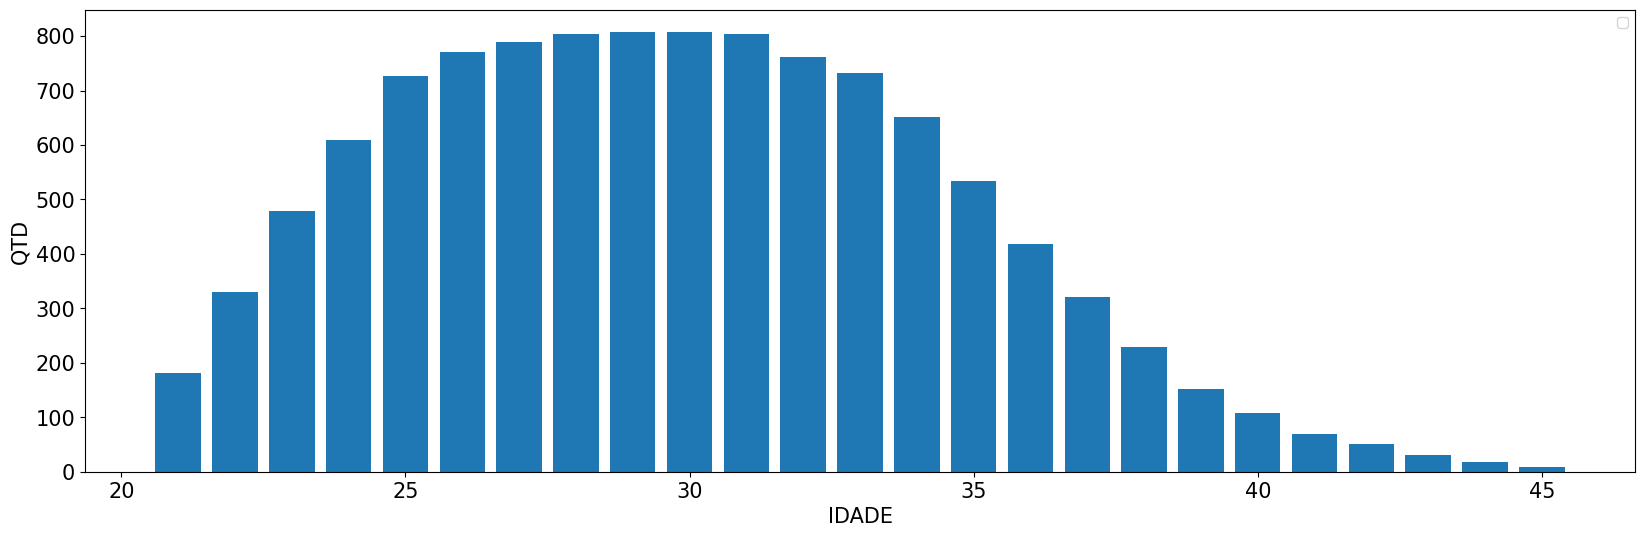

In [100]:
df_pitching5 = df_pitching4.loc[(df_pitching4.seasons_played>=10) &
                                (df_pitching4.yearID<=2019) &
                                (df_pitching4.yearID>=1970) &
                                (df_pitching4.age>=21) &
                                (df_pitching4.age<=45)]

### Contagem de jogadores por Idade entre 1960 e 2019
df_pitching_age = df_pitching5.groupby(['age'],as_index=False).agg({'playerID':'count'})
df_pitching_age.age = df_pitching_age.age.astype('int64')
plt.figure(figsize=(20,6))
plt.bar(x='age',height='playerID',data=df_pitching_age)
#plt.title("Qtd. Arremessadores por Idade",fontsize=20)
plt.legend([])
plt.xlabel('IDADE',fontsize=15)
plt.ylabel('QTD',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

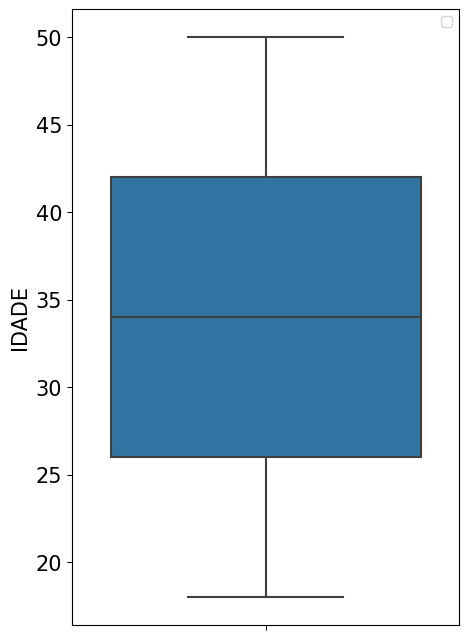

In [106]:
plt.figure(figsize=(5,8))
sns.boxplot(y='age',data=df_pitching4.loc[(df_pitching4.seasons_played>=10) &
                                          (df_pitching4.yearID<=2019) &
                                          (df_pitching4.yearID>=1970)]\
                                     .groupby(['age'],as_index=False).agg({'playerID':'count'}))

#plt.title("Arremessadores por Idade")
plt.legend([])
plt.xlabel('')
plt.ylabel('IDADE',fontsize=15)
#plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

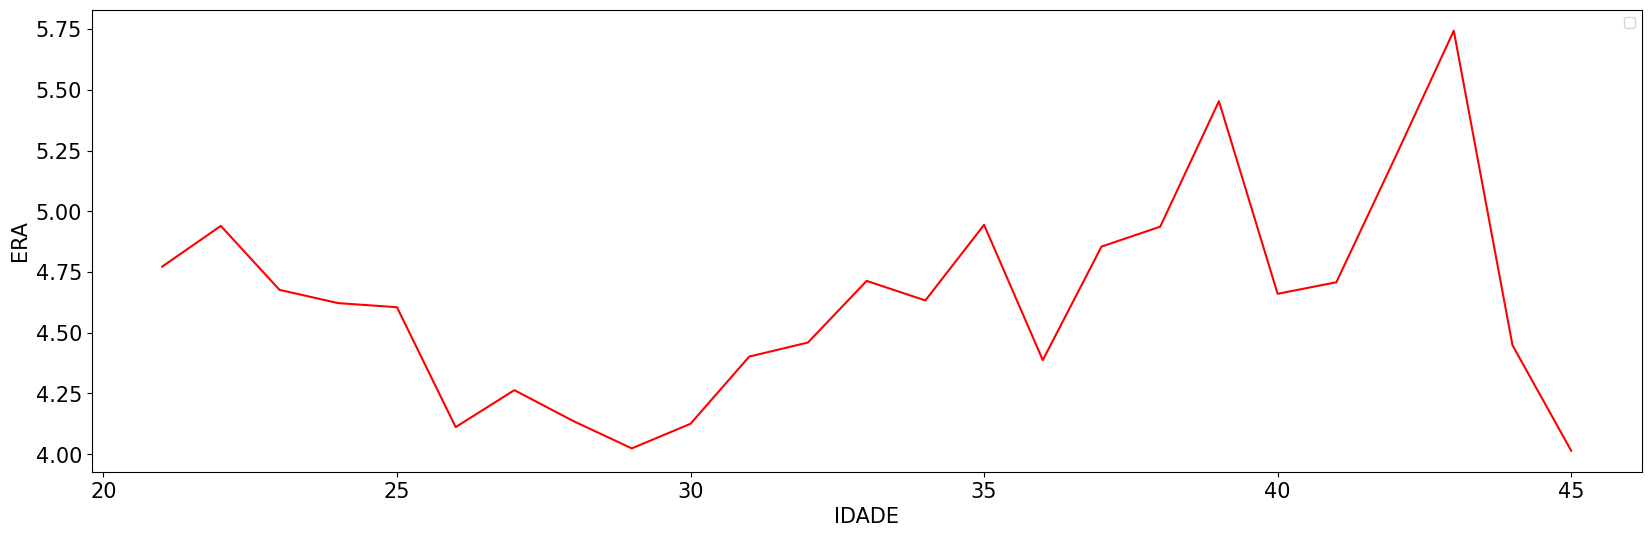

In [101]:
y='ERA'
x='age'
plt.figure(figsize=(20,6))
sns.lineplot(data=df_pitching5.groupby(['age'],as_index=False)\
                              .agg({y:'mean'}),x=x,y=y,color='red')
#plt.title("ERA x IDADE")
plt.legend([])
plt.xlabel('IDADE',fontsize=15)
plt.ylabel('ERA',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

#### Rebatedores

In [48]:
df_batting4 = df_batting3.merge(df_players2,on=['playerID'])\
                         .merge(df_salaries[['playerID','yearID','salary']],
                                on=['playerID','yearID'],how='left')\
                         .merge(df_college2[['playerID','schoolID']],on=['playerID'],how='left')\
                         .merge(df_defense4,on=['playerID','yearID'],how='left')\
                         .merge(df_appearances[['playerID','yearID','POS_OFENSE']],on=['playerID','yearID'],how='left')

df_batting4['age'] = df_batting4.yearID-df_batting4.birthYear ### Idade dos jogadores em cada temporada

### Ajuste da idade de acordo com informações da base de WAR

df_batting4['age'] = np.where(df_batting4.age_war.isna(),df_batting4.age,df_batting4.age_war)
df_batting4.age = df_batting4.age.astype('int64')

### Salário dos jogadores ajustado de acordo com as duas bases

df_batting4['salary_ajs'] = np.where(df_batting4.salary.isna(),df_batting4.salary_war,df_batting4.salary)

### Definição dos jogadores que atuaram mais da metade dos jogos como DH

df_batting4['POS'] = np.where(df_batting4.POS_OFENSE=='DH',df_batting4.POS_OFENSE,df_batting4.POS)

### IMC dos jogadores para futura análise de correlação de IMC e salário x performance

df_batting4['IMC'] = (df_batting4.weight*0.453592)/((df_batting4.height*0.0254)**2)
df_batting4['FAIXA_IMC'] = np.where(df_batting4.IMC<18.5,'Magreza',
                           np.where(df_batting4.IMC<25,'Saudável',
                           np.where(df_batting4.IMC<30,'Sobrepeso',
                           np.where(df_batting4.IMC<35,'Obesidade 1','Obesidade 2'))))

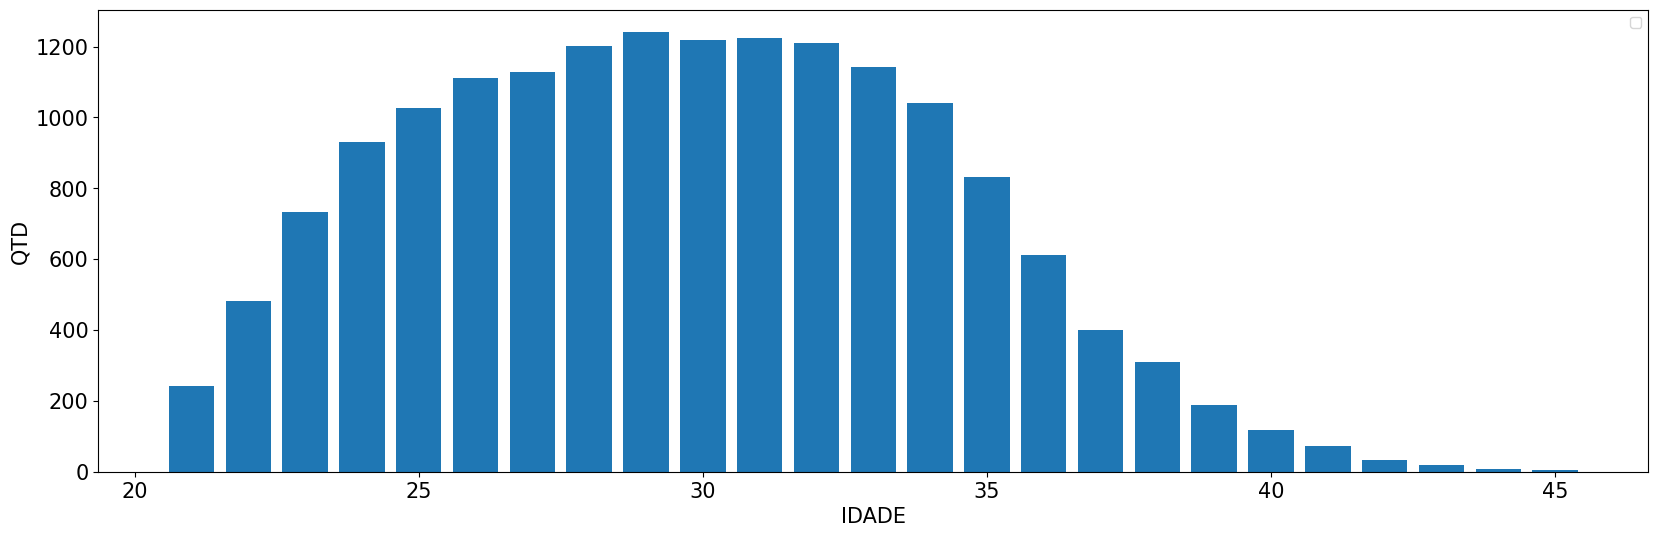

In [102]:
df_batting5 = df_batting4.loc[(df_batting4.seasons_played>=10) &
                              (df_batting4.yearID<=2019) &
                              (df_batting4.yearID>=1970) &
                              (df_batting4.age>=21) &
                              (df_batting4.age<=45) &
                              (df_batting4.POS!='P')]

### Contagem de jogadores por Idade entre 1960 e 2019
df_batting_age = df_batting5.groupby(['age'],as_index=False).agg({'playerID':'count'})
plt.figure(figsize=(20,6))
plt.bar(x='age',height='playerID',data=df_batting_age)
#plt.title("Qtd. Rebatedores por Idade")
plt.legend([])
plt.xlabel('IDADE',fontsize=15)
plt.ylabel('QTD',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

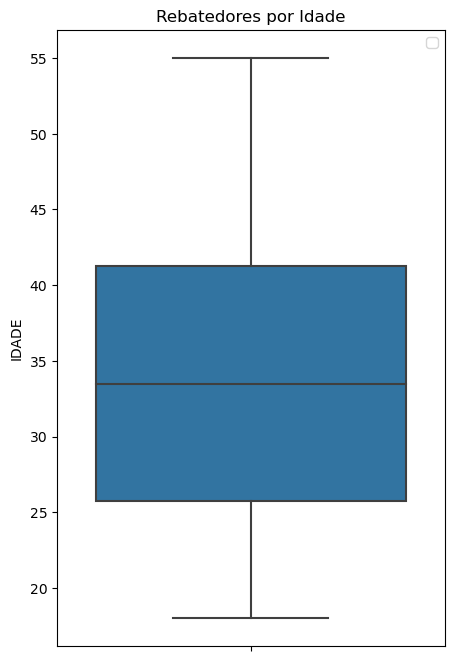

In [50]:
plt.figure(figsize=(5,8))
sns.boxplot(y='age',data=df_batting4.loc[(df_batting4.seasons_played>=10) &
                                         (df_batting4.yearID<=2019) &
                                         (df_batting4.yearID>=1970) &
                                         (df_batting4.POS!='P')]\
                                    .groupby(['age'],as_index=False).agg({'playerID':'count'}))

plt.title("Rebatedores por Idade")
plt.legend([])
plt.xlabel('')
plt.ylabel('IDADE');

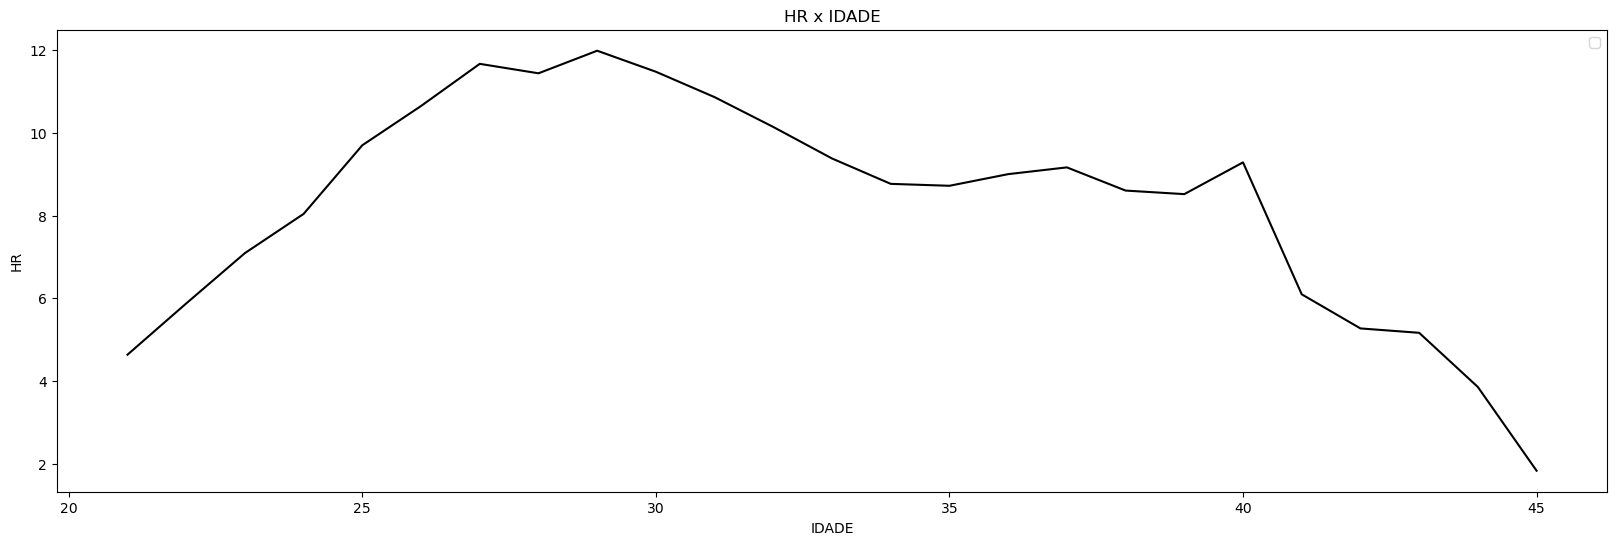

In [51]:
y='HR'
x='age'
plt.figure(figsize=(20,6))
sns.lineplot(data=df_batting5.groupby(['age'],as_index=False)\
                             .agg({y:'mean'}),x=x,y=y,color='black')
plt.title("HR x IDADE")
plt.legend([])
plt.xlabel('IDADE')
plt.ylabel('HR');

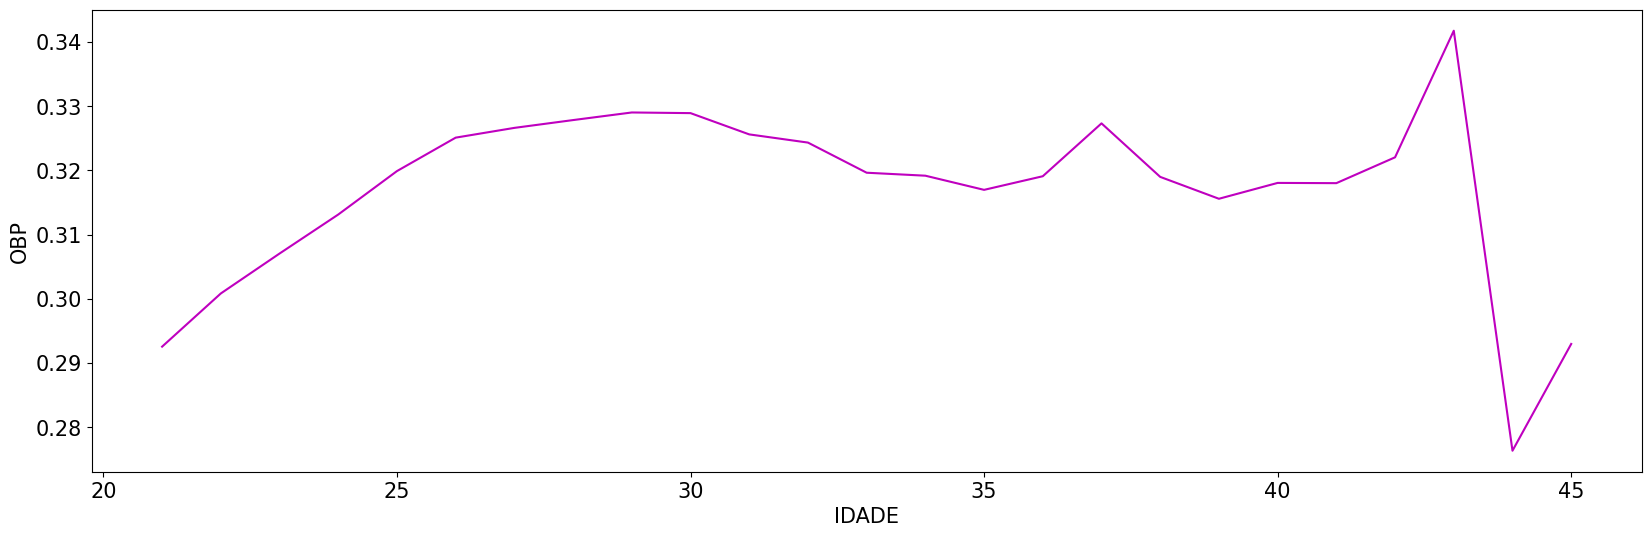

In [104]:
y='OBP'
#y2='OPS'
x='age'
plt.figure(figsize=(20,6))
sns.lineplot(data=df_batting5.groupby(['age'],as_index=False)\
                             .agg({y:'mean'}),x=x,y=y,color='m')
#sns.lineplot(data=df_batting5.groupby(['age'],as_index=False)\
#                             .agg({y2:'mean'}),x=x,y=y2,color='r')
#plt.title("OBP x IDADE")
#plt.legend([y,z])
plt.xlabel('IDADE',fontsize=15)
plt.ylabel('OBP',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

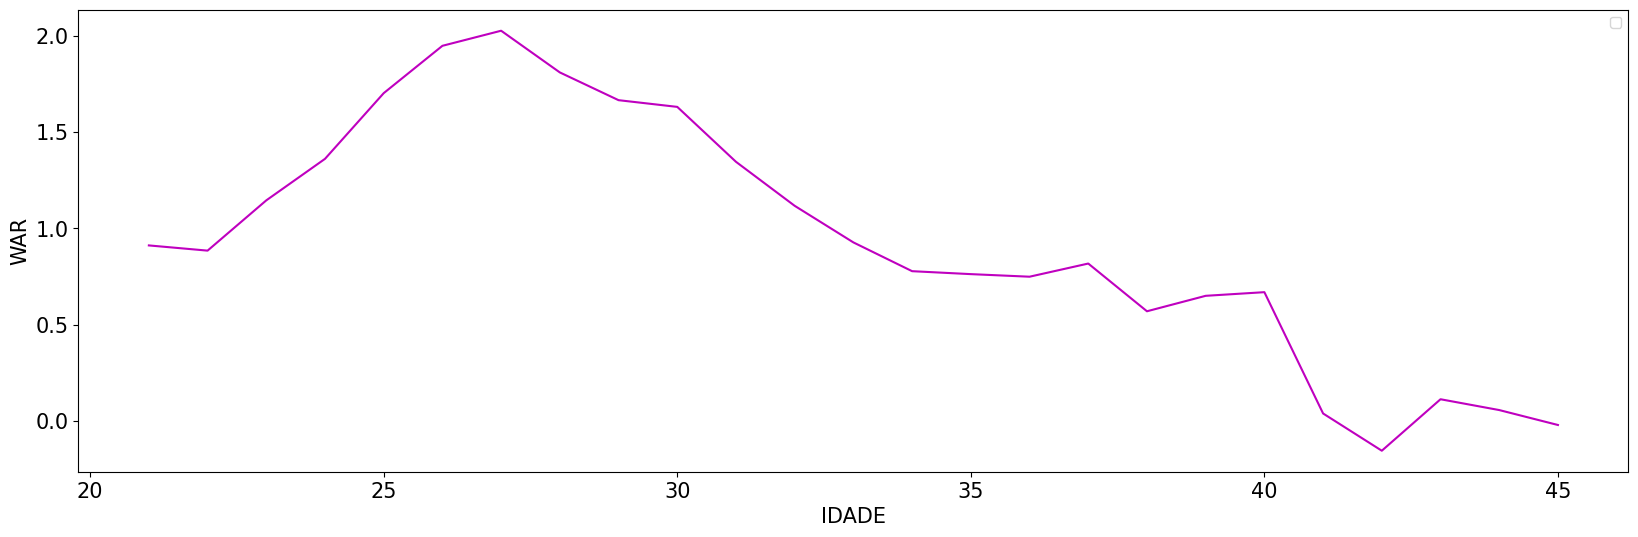

In [103]:
y='WAR'
x='age'
plt.figure(figsize=(20,6))
sns.lineplot(data=df_batting5.groupby(['age'],as_index=False)\
                             .agg({y:'mean'}),x=x,y=y,color='m')
#plt.title("WAR x IDADE")
plt.legend([])
plt.xlabel('IDADE',fontsize=15)
plt.ylabel('WAR',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

### Qual estatística tem maior correlação com as corridas e vitórias?

In [54]:
### Até 1969 SF e HBP não eram contabilizados, o que significa que OBP e AVG ficam iguais nesse período

df_teams2 = df_teams.loc[(df_teams.yearID>=1970) & ### inicio da contagem de HBP e SF
                         (df_teams.yearID<=2019) & ### pré-pandemia
                         (df_teams.yearID!=1981) & ### greve
                         (df_teams.yearID!=1994) & ### greve
                         (df_teams.yearID!=1995)]  ### greve

In [55]:
df_teams2.tail(1)

yearID lgID teamID franchID divID  Rank    G     Ghome   W   L DivWin  \
2924    2019   NL    WAS      WSN     E     2  162 81.000000  93  69      N   

     WCWin LgWin WSWin    R    AB     H   2B  3B   HR         BB          SO  \
2924     Y     Y     Y  873  5512  1460  298  27  231 584.000000 1308.000000   

             SB        CS       HBP        SF   RA   ER      ERA  CG  SHO  SV  \
2924 116.000000 29.000000 81.000000 42.000000  724  683 4.270000   1   13  40   

      IPouts    HA  HRA  BBA   SOA   E   DP       FP                  name  \
2924    4318  1340  202  517  1511  87  111 0.985000  Washington Nationals   

                park     attendance  BPF  PPF teamIDBR teamIDlahman45  \
2924  Nationals Park 2259781.000000  106  104      WSN            MON   

     teamIDretro  saldo_corridas  saldo_corridas_creditadas      AVG  \
2924         WAS             149                        190 0.264877   

              PA      OBP   1B    TB      SLG      OPS   R_create  \
2924 6219.000000 0.341695  904  2505 0.454463 0.796158 773.260459   

      R_create_x_R  SB_percentage  R_per_H  R_per_BAP  R_per_SB  
2924     -0.114249       0.800000 1.672394   2.434135  0.132875

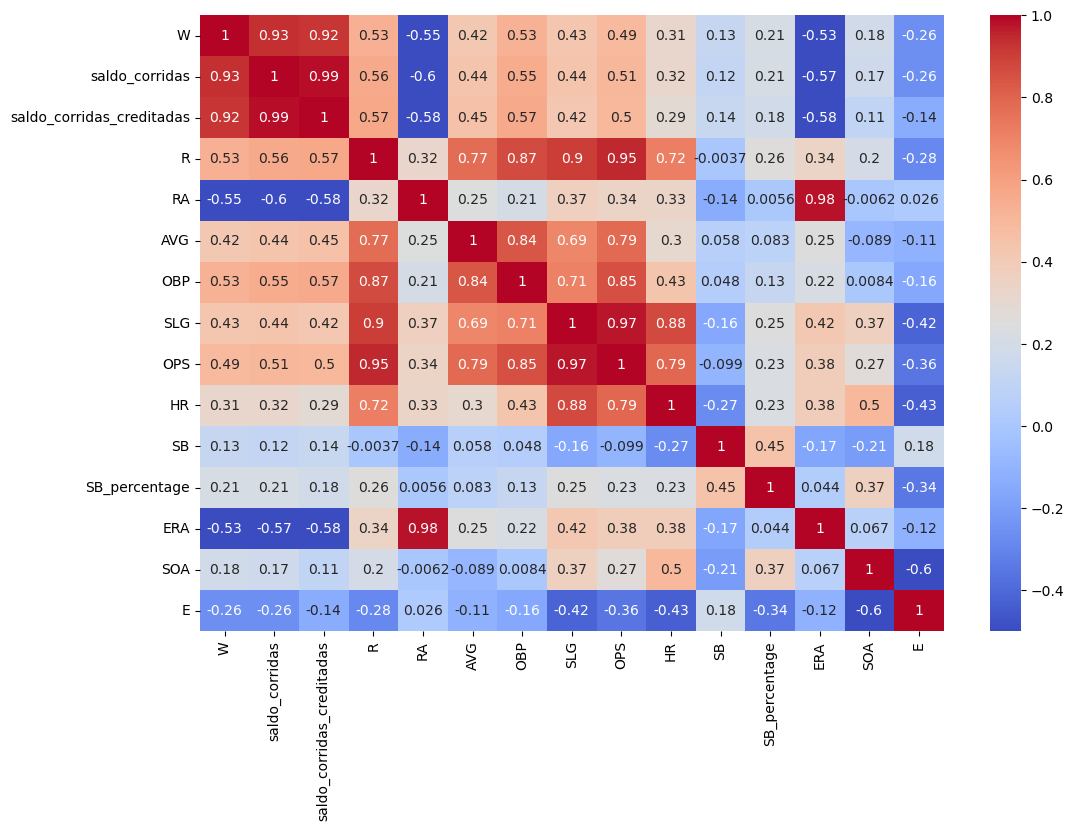

In [56]:
plt.figure(figsize=(12,8))
colunas = ['W','saldo_corridas','saldo_corridas_creditadas','R','RA','AVG','OBP','SLG','OPS','HR','SB','SB_percentage',
           'ERA','SOA','E']
corrMatrix = df_teams2[colunas].corr()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm',vmin=-0.5)
plt.show()

- É possível observar que saldo de corridas estão altamento correlacionados com as vitórias (como era esperado). 
- OBP e OPS apresentam maior correlação com corridas e vitórias do que AVG.
- ERA apresenta forte correlação (inversa) com o número de vitórias.
- SB e percentual de SB bem sucedidos não aprensetam correlação forte com as vitórias ou com o número de corridas anotadas.

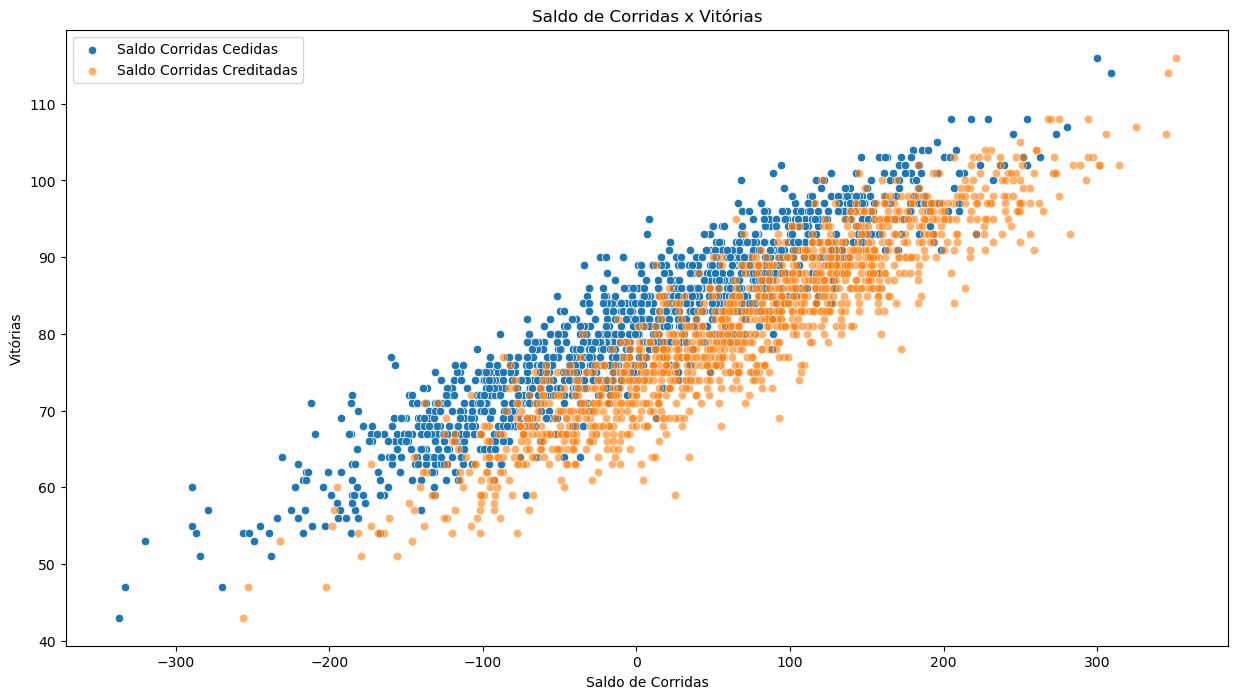

In [57]:
y='W'
x='saldo_corridas'
x2 = 'saldo_corridas_creditadas'
plt.figure(figsize=(15,8))
sns.scatterplot(df_teams2[x],df_teams2[y],alpha=1)
sns.scatterplot(df_teams2[x2],df_teams2[y],alpha=0.6)
plt.title("Saldo de Corridas x Vitórias")
plt.legend(['Saldo Corridas Cedidas','Saldo Corridas Creditadas'])
plt.xlabel('Saldo de Corridas')
plt.ylabel('Vitórias');

No gráfico de dispersão é possível observar a forte correlação de saldo de corridas cedidas e totais com a contagem de vitórias.

In [58]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return round(np.mean(np.abs((y_true-y_pred)/y_true))*100,2)

In [59]:
def linear_regression(x1,y1):
    X = np.array(x1).reshape(-1, 1)
    y = np.array(y1).reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

    modelo_rl = LinearRegression()

    modelo_rl.fit(X_train, y_train)
    forecast_rl = modelo_rl.predict(X_test)

    rsme = np.sqrt(mean_squared_error(y_test, forecast_rl))
    r2 = r2_score(y_test, forecast_rl)
    mape = mean_absolute_percentage_error(y_test,forecast_rl)
    mae = mean_absolute_error(y_test,forecast_rl)


    print('RSME:',rsme)
    print('R²:',r2)
    print('MAPE:',mape)
    print('MAE:',mae)
    scores = cross_val_score(modelo_rl, X, y, cv=5)
    print("Scores cv: ",scores)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    return X_test, y_test, modelo_rl, r2

In [109]:
X_test, y_test, modelo_rl, r2 = linear_regression(df_teams2['saldo_corridas'],df_teams2['W'])

RSME: 3.858377834796603
R²: 0.8923527026994572
MAPE: 4.06
MAE: 3.180583091829525
Scores cv:  [0.86440956 0.85859523 0.88028264 0.87139679 0.88575964]
0.87 accuracy with a standard deviation of 0.01


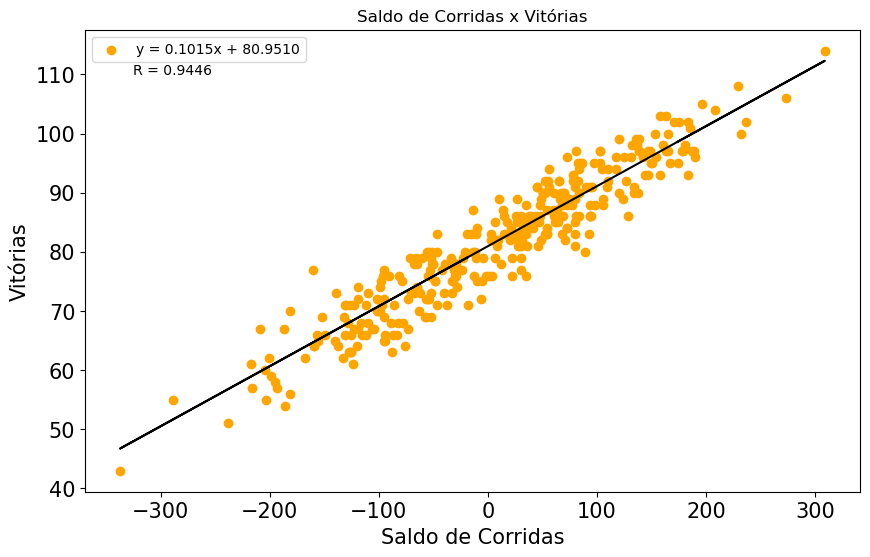

In [112]:
y_pred = modelo_rl.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color ='orange')
plt.plot(X_test, y_pred, color ='k')
plt.text(x=-325,y=110,s='R = {:.4f}'.format(np.sqrt(r2)),fontsize=10)
plt.legend(['y = {:.4f}x + {:.4f}'.format(modelo_rl.coef_[0][0], modelo_rl.intercept_[0])])
plt.title("Saldo de Corridas x Vitórias")
plt.xlabel('Saldo de Corridas',fontsize=15)
plt.ylabel('Vitórias',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

A cada saldo positivo de 10 corridas, aproximadamente, equivale a 1 vitória

In [114]:
X_test, y_test, modelo_rl, r2 = linear_regression(df_teams2['ERA'],df_teams2['ER'])

RSME: 7.146661349625781
R²: 0.9937781445709738
MAPE: 0.82
MAE: 5.097061857199847
Scores cv:  [0.9811687  0.99255034 0.99619315 0.99433321 0.99565373]
0.99 accuracy with a standard deviation of 0.01


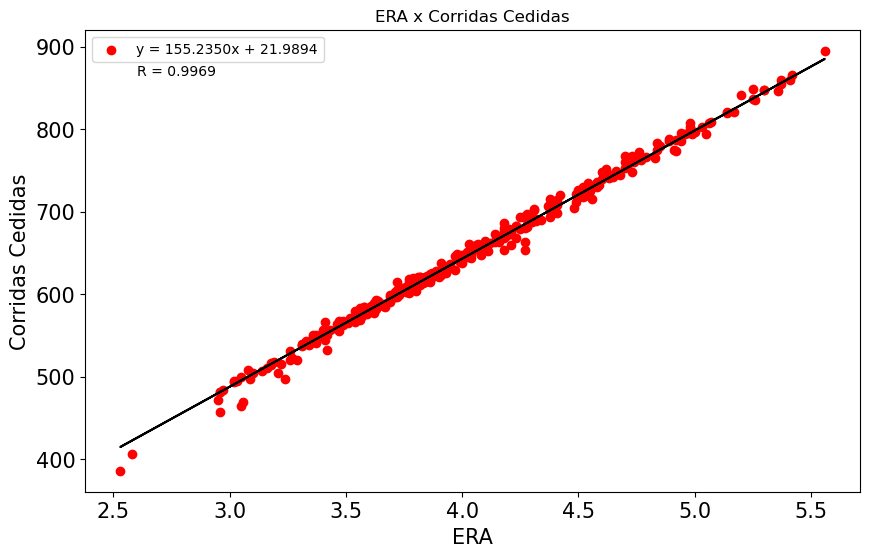

In [116]:
y_pred = modelo_rl.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color ='red')
plt.plot(X_test, y_pred, color ='k')
plt.text(x=2.6,y=865,s='R = {:.4f}'.format(np.sqrt(r2)),fontsize=10)
plt.legend(['y = {:.4f}x + {:.4f}'.format(modelo_rl.coef_[0][0], modelo_rl.intercept_[0])])
plt.title("ERA x Corridas Cedidas")
plt.xlabel('ERA',fontsize=15)
plt.ylabel('Corridas Cedidas',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

#### OBP x AVG x SLG (Ataque)

O que é mais importante? Média de rebatidas válidas (AVG), a média de chegadas em base (OBP) e/ou a potência (SLG)?

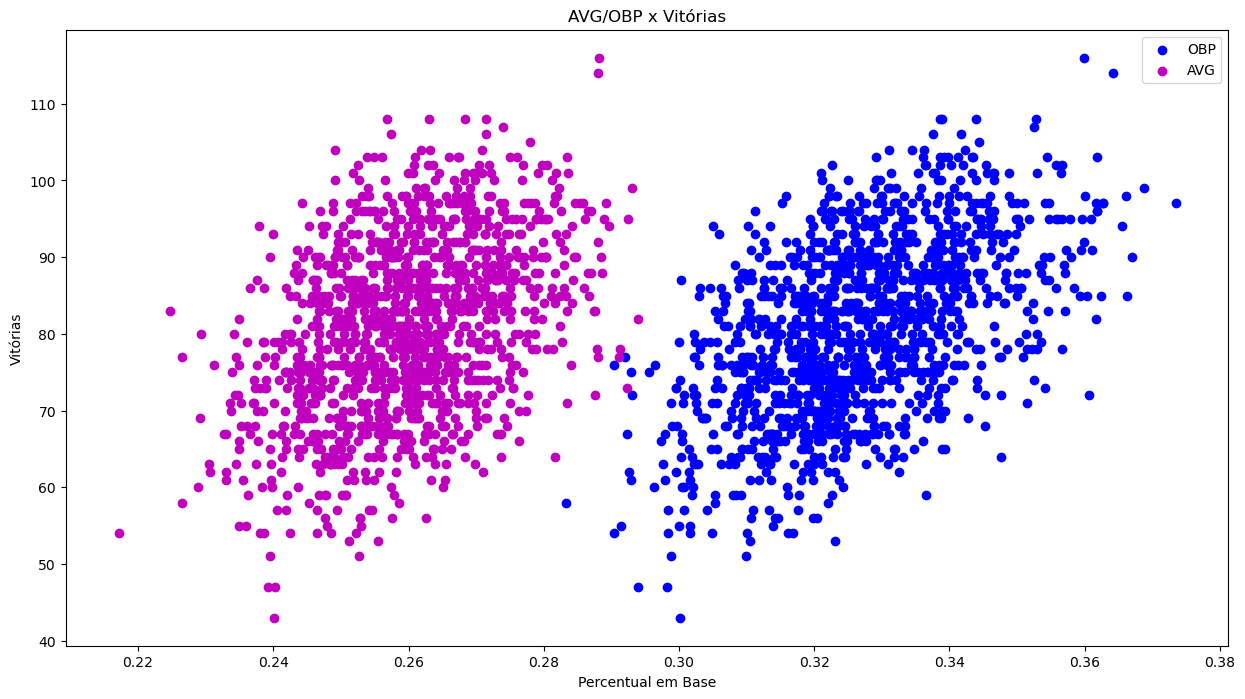

In [65]:
y='W'
x='OBP'
x2 = 'AVG'
plt.figure(figsize=(15,8))
plt.scatter(df_teams2[x],df_teams2[y],color='b')
plt.scatter(df_teams2[x2],df_teams2[y],color='m')
plt.title("AVG/OBP x Vitórias")
plt.legend(['OBP','AVG'])
plt.xlabel('Percentual em Base')
plt.ylabel('Vitórias');

Há uma correlação pareceda entre OBP e AVG com relação ao número de vitórias, apesar da OBP apresentar uma leve tendência de produzir mais vitórias.

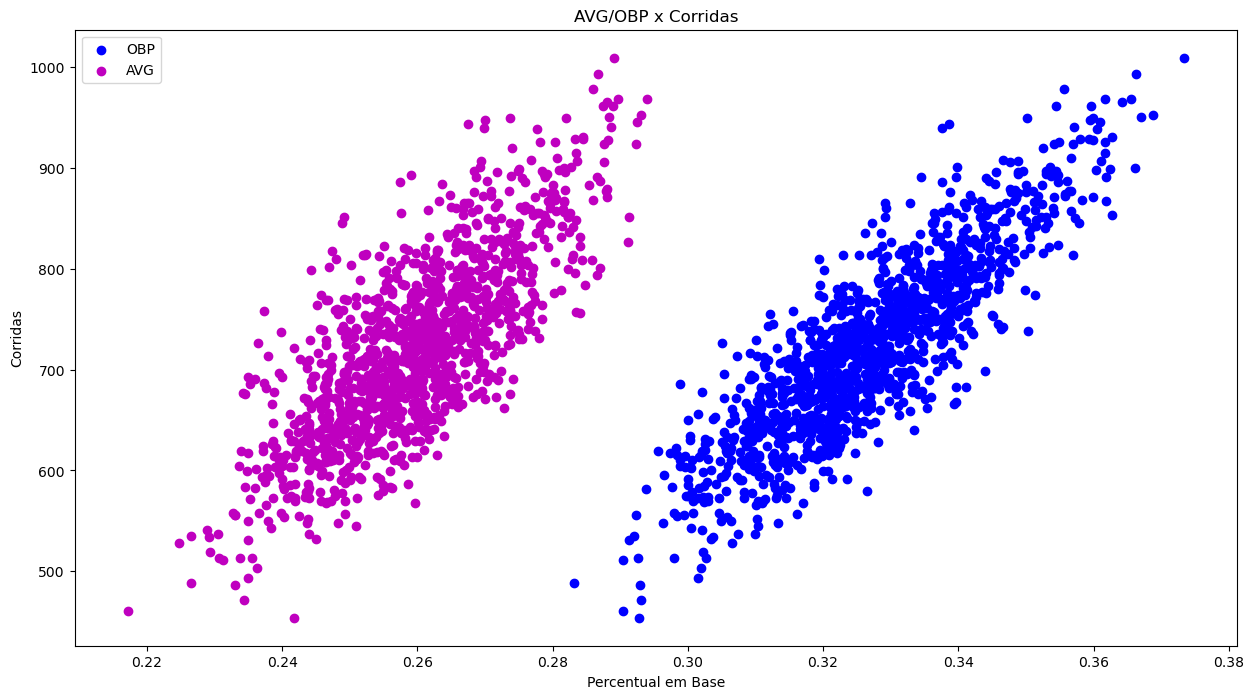

In [66]:
y='R'
x='OBP'
x2 = 'AVG'
plt.figure(figsize=(15,8))
plt.scatter(df_teams2[x],df_teams2[y],color='b')
plt.scatter(df_teams2[x2],df_teams2[y],color='m')
plt.title("AVG/OBP x Corridas")
plt.legend(['OBP','AVG'])
plt.xlabel('Percentual em Base')
plt.ylabel('Corridas');

Ao comparar AVG e OBP com as corridas anotadas é possível observar uma correlação maior do % de chegadas em base do que simplesmente a média de rebatidas, o que mostra a importância dos Walks (BB)

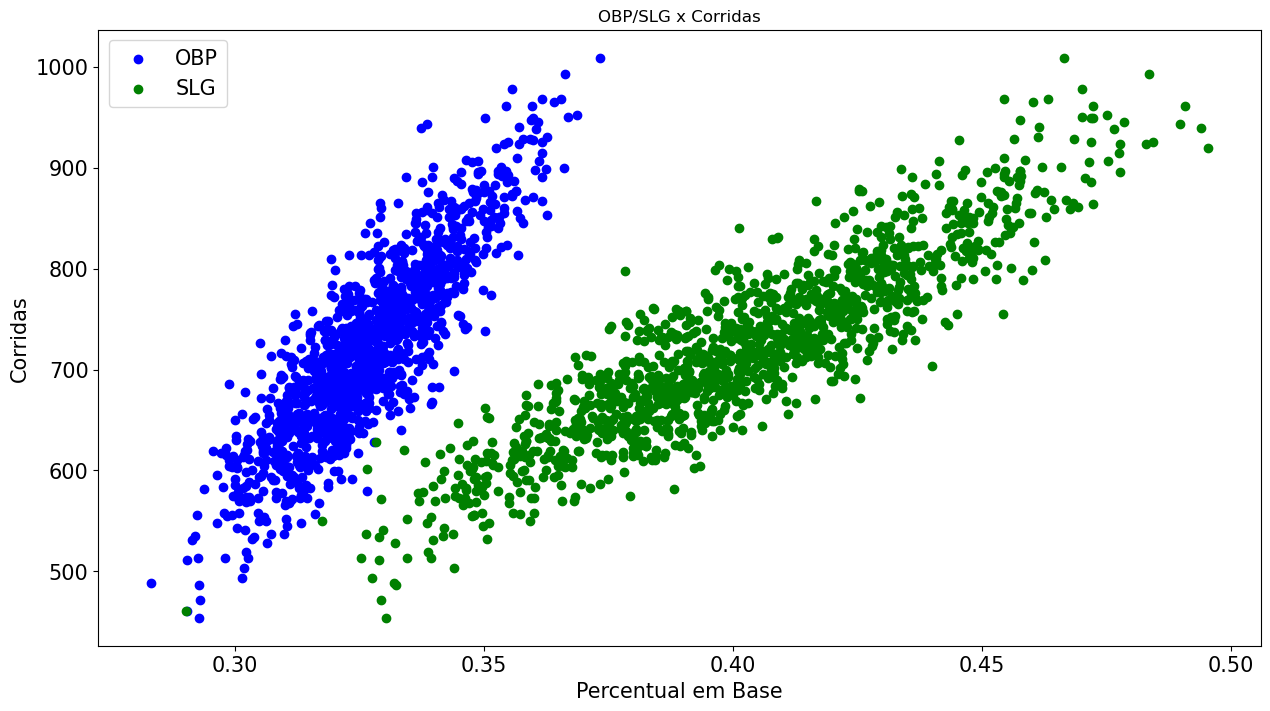

In [118]:
y='R'
x='OBP'
x2 = 'SLG'
plt.figure(figsize=(15,8))
plt.scatter(df_teams2[x],df_teams2[y],color='b')
plt.scatter(df_teams2[x2],df_teams2[y],color='g')
plt.title("OBP/SLG x Corridas")
plt.legend(['OBP','SLG'],fontsize=15)
plt.xlabel('Percentual em Base',fontsize=15)
plt.ylabel('Corridas',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Página 147 Moneyball: "1% a mais de OBP equivale a 3% a mais de SLG no ganho de corridas"

In [120]:
X_test, y_test, modelo_rl, r2 = linear_regression(df_teams2['OBP'],df_teams2['R'])

RSME: 46.49599705147389
R²: 0.7699225732787194
MAPE: 5.09
MAE: 36.21701137465635
Scores cv:  [0.54440241 0.66555266 0.82615496 0.74285727 0.41247243]
0.64 accuracy with a standard deviation of 0.15


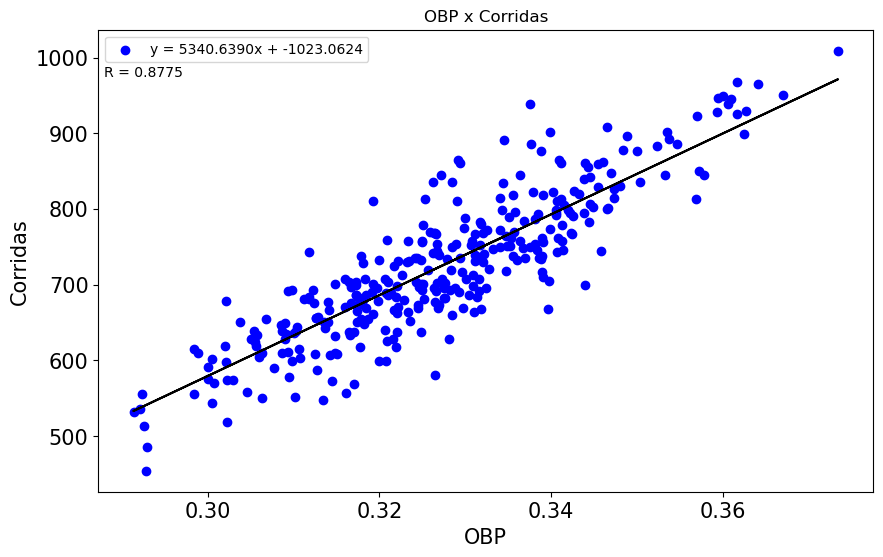

In [122]:
y_pred = modelo_rl.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')
plt.text(x=0.2879,y=975,s='R = {:.4f}'.format(np.sqrt(r2)),fontsize=10)
plt.legend(['y = {:.4f}x + {:.4f}'.format(modelo_rl.coef_[0][0], modelo_rl.intercept_[0])])
plt.title("OBP x Corridas")
plt.xlabel('OBP',fontsize=15)
plt.ylabel('Corridas',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Cada ponto percentual de OBP equivale a, aproximadamente, 53 corridas e já observamos que cada saldo de 10 corridas equivale a 1 vitória, aproximadamente. Ou seja, cada ponto percentual de OBP pode retornar 5 vitórias a mais na temporada.

In [124]:
X_test, y_test, modelo_rl, r2 = linear_regression(df_teams2['SLG'],df_teams2['R'])

RSME: 38.45075595038582
R²: 0.8426551088405313
MAPE: 4.32
MAE: 30.751653430873304
Scores cv:  [0.7657182  0.74963442 0.77099518 0.78907395 0.66045867]
0.75 accuracy with a standard deviation of 0.05


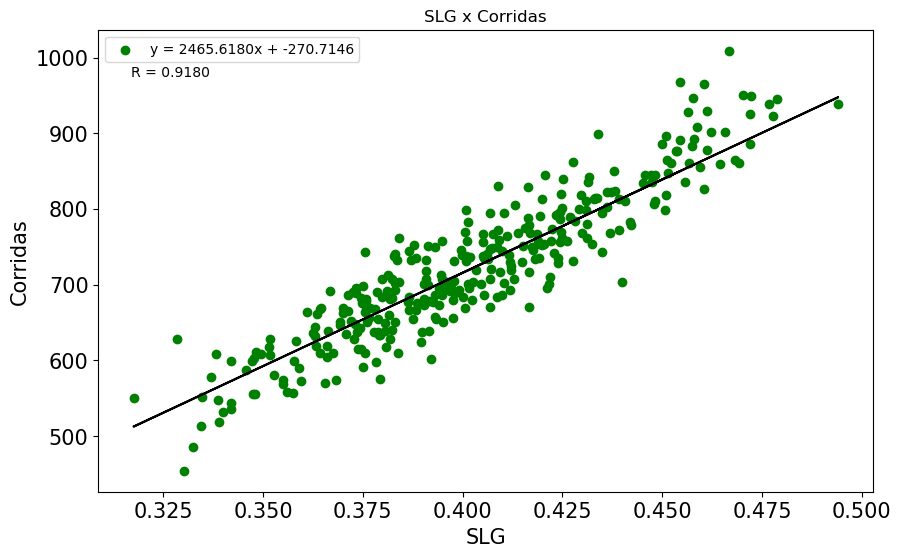

In [126]:
y_pred = modelo_rl.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color ='g')
plt.plot(X_test, y_pred, color ='k')
plt.text(x=0.317,y=975,s='R = {:.4f}'.format(np.sqrt(r2)),fontsize=10)
plt.legend(['y = {:.4f}x + {:.4f}'.format(modelo_rl.coef_[0][0], modelo_rl.intercept_[0])])
plt.title("SLG x Corridas")
plt.xlabel('SLG',fontsize=15)
plt.ylabel('Corridas',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Cada ponto percentual de SLG equivale a, aproximadamente, 25 corridas, ou 2.5 vitórias. Conforme descrito no Moneyball, cada ponto percentual de OBP pode significar o dobro a mais de vitórias em relação cada ponto percentual de SLG.

In [72]:
X_test, y_test, modelo_rl, r2 = linear_regression(df_teams2['OPS'],df_teams2['R'])

RSME: 27.652312694239274
R²: 0.9186222271690347
MAPE: 3.07
MAE: 21.91162235048239
Scores cv:  [0.89935834 0.83055838 0.89978611 0.87260219 0.88311619]
0.88 accuracy with a standard deviation of 0.03


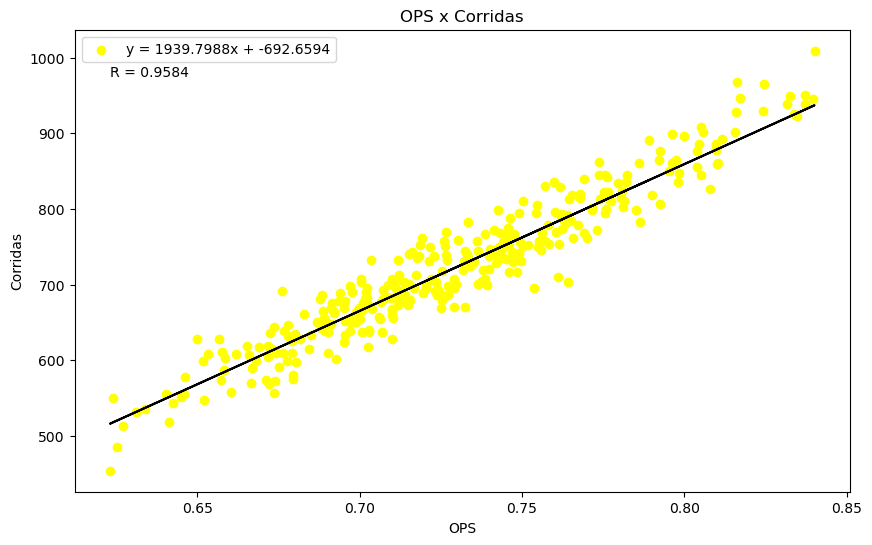

In [73]:
y_pred = modelo_rl.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color ='yellow')
plt.plot(X_test, y_pred, color ='k')
plt.text(x=0.623,y=975,s='R = {:.4f}'.format(np.sqrt(r2)),fontsize=10)
plt.legend(['y = {:.4f}x + {:.4f}'.format(modelo_rl.coef_[0][0], modelo_rl.intercept_[0])])
plt.title("OPS x Corridas")
plt.xlabel('OPS')
plt.ylabel('Corridas');

Cada ponto percentual de OPS, acrescenta, aproximadamente, 19 corridas, que sinigicam, aproximadamente, 2 vitórias.

In [74]:
X_test, y_test, modelo_rl, r2 = linear_regression(df_teams2['ERA'],df_teams2['W'])

RSME: 10.380237864582663
R²: 0.2208730380859597
MAPE: 10.71
MAE: 8.331441068692559
Scores cv:  [0.03881396 0.21187333 0.13365617 0.2818084  0.41802501]
0.22 accuracy with a standard deviation of 0.13


In [127]:
#%%time

#features = ['OBP','AVG','OPS','SLG']
features2 = ['OBP','AVG','SLG']
features3 = ['OBP','AVG']
lista_features = [features2,features3]
lista_teste = [0.2,0.25,0.3]
lista_max_depth = [4,8,12,16]
lista_estimators = [100,200,300]
lista_criterion = ['mse','mae']
melhor_rsme_rndf=10000000
melhor_score_rndf = 0
cont=0

for features in lista_features:   
    
    X = df_teams2[features]
    y = df_teams2['R']

    for teste in lista_teste:
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=teste, random_state=42)
        for scale in [True,False]:
            if(scale==True):
                scaler  = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test  = scaler.transform(X_test)
                
            for max_depth in lista_max_depth:
                for estimators in lista_estimators:
                    for criterion in lista_criterion:
                        modelo_rf = RandomForestRegressor(min_samples_leaf=1,max_depth=max_depth,
                                                          n_estimators=estimators,criterion=criterion)

                        m_rf = modelo_rf.fit(X_train, y_train)
                        forecast = m_rf.predict(X_test)

                        rsme = np.sqrt(mean_squared_error(y_test, forecast))
                        r2 = r2_score(y_test, forecast)
                        mape = mean_absolute_percentage_error(y_test,forecast)
                        mae = mean_absolute_error(y_test,forecast)
                        score = m_rf.score(X_test,y_test)

                        if(score>melhor_score_rndf):
                            melhor_rsme_rndf = rsme
                            melhor_r2_rndf = r2
                            melhor_mape_rndf = mape
                            melhor_mae_rndf = mae
                            percentual_teste = teste
                            melhor_max_depth = max_depth
                            melhor_criterion = criterion
                            melhor_estimator = estimators
                            melhor_modelo = modelo_rf
                            melhor_rf = m_rf
                            melhor_X = X
                            melhor_y = y
                            melhor_features_rndf = features
                            melhor_score_rndf = score

                            if(scale==True):
                                melhor_scale='Com Scale'
                            else:
                                melhor_scale='Sem Scale'
                        cont = cont+1
                        #print('Combinação:', cont)
                                    
print('Melhor RMSE:',melhor_rsme_rndf)
print('Melhor R²:',melhor_r2_rndf)
print('Melhor MAPE:',melhor_mape_rndf)
print('Melhor MAE:',melhor_mae_rndf)
print('Melhor Score:',melhor_score_rndf)
print('Melhor lista de features:',melhor_features_rndf)
print('Melhor % de Teste:',percentual_teste)
print('Melhor Max Depth:',melhor_max_depth)
print('Melhor Estimators:',melhor_estimator)
print('Melhor Criterion:',melhor_criterion)
print('Scale:',melhor_scale)
scores = cross_val_score(m_rf, melhor_X, melhor_y, cv=5)
print("Scores: ",scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Melhor RMSE: 28.708049870825807
Melhor R²: 0.9122897668871022
Melhor MAPE: 3.23
Melhor MAE: 22.976104294478525
Melhor Score: 0.9122897668871022
Melhor lista de features: ['OBP', 'AVG', 'SLG']
Melhor % de Teste: 0.25
Melhor Max Depth: 8
Melhor Estimators: 300
Melhor Criterion: mae
Scale: Com Scale
Scores:  [0.87258168 0.80537014 0.90739511 0.87349697 0.87224728]
0.87 accuracy with a standard deviation of 0.03


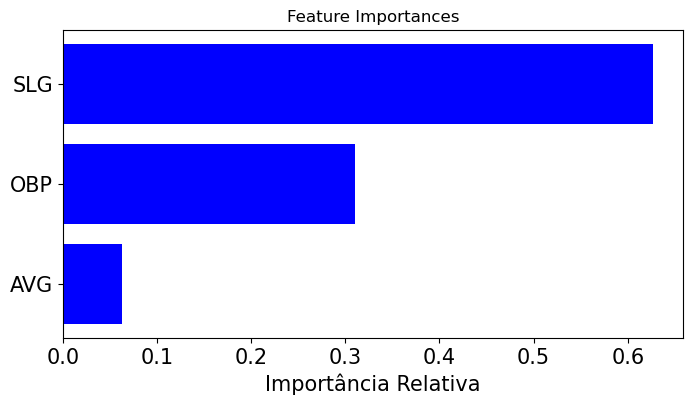

In [129]:
importances = melhor_rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [melhor_features_rndf[i] for i in indices],fontsize=15)
plt.xlabel('Importância Relativa',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Ao colocar as principais features de ataque num modelo de regressão é possível observar a importância da potência (SLG) na criação de corridas, seguido da OBP e com menor importância para a média de rebatidas (AVG).

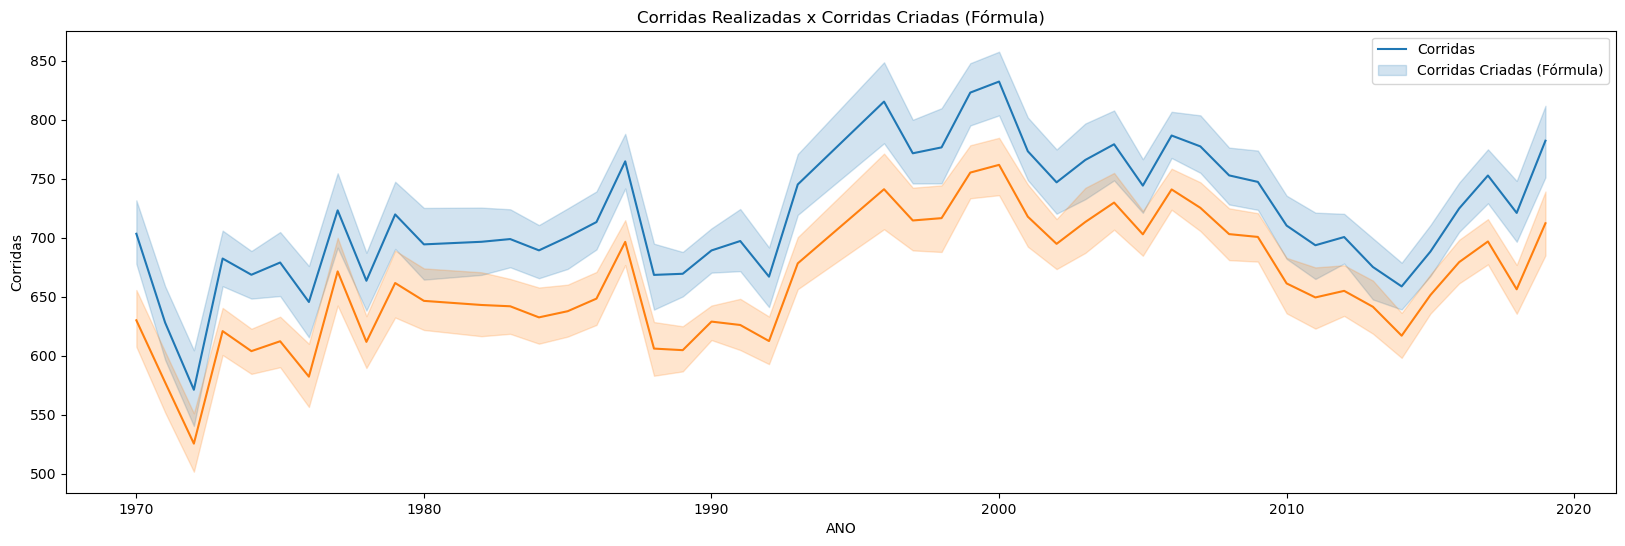

In [77]:
### Testando fórmula do Bill James em Baseball Abstract para chegar nas corridas anotadas

y='R'
y2='R_create'
x='yearID'
plt.figure(figsize=(20,6))
sns.lineplot(data=df_teams2,x=x,y=y)
sns.lineplot(data=df_teams2,x=x,y=y2)
plt.title("Corridas Realizadas x Corridas Criadas (Fórmula)")
plt.legend(['Corridas','Corridas Criadas (Fórmula)'])
plt.xlabel('ANO')
plt.ylabel('Corridas');

Fórmula criada por Bill James no livro Baseball Abstratct na década de 1980 mostra a forte relação com as corridas anotadas pelos times por temporada, mostrando a importância dos walks e HBP, além da potência no bastão representado pelo TB como multiplicador

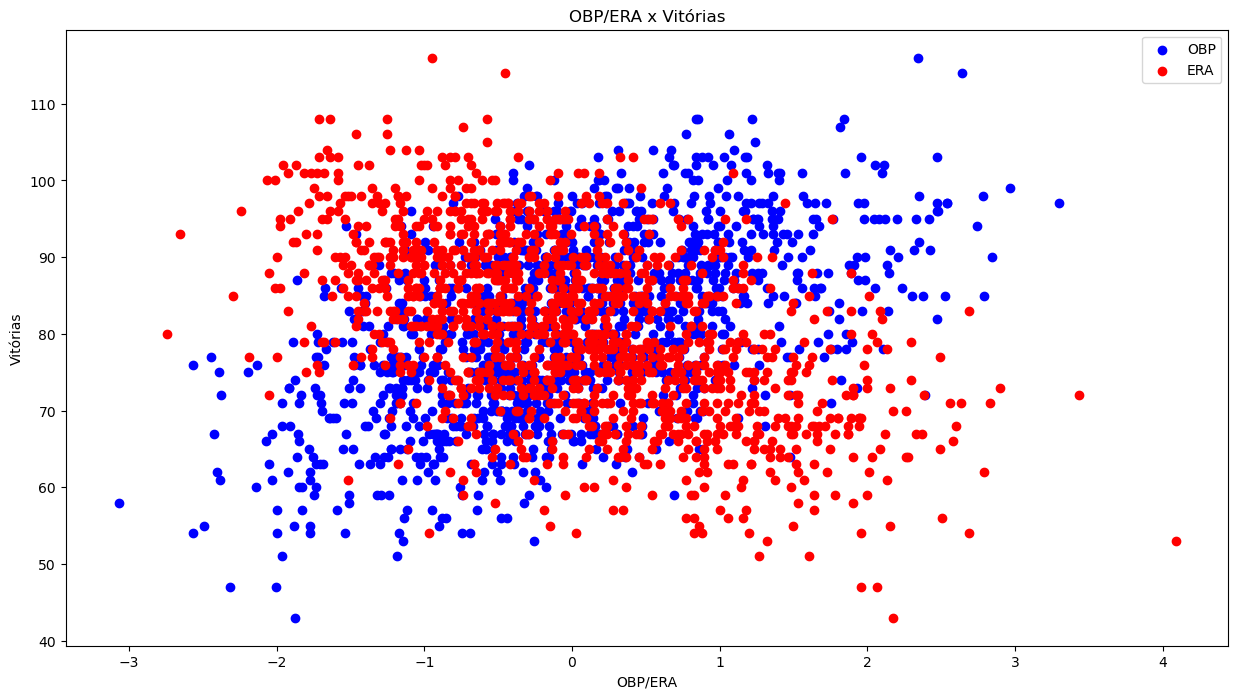

In [78]:
### ERA x OBP - Importância do arremessador e rebatedores nas vitórias

scaler  = StandardScaler()
df_teams3 = scaler.fit_transform(df_teams2[['ERA','OBP']])
df_teams3 = pd.DataFrame(df_teams3,columns=['ERA','OBP'])\
              .merge(df_teams2[['W']].reset_index(),left_index=True,right_index=True)
y='W'
x='OBP'
x2 = 'ERA'
plt.figure(figsize=(15,8))
plt.scatter(df_teams3[x],df_teams3[y],color='b')
plt.scatter(df_teams3[x2],df_teams3[y],color='r')
plt.title("OBP/ERA x Vitórias")
plt.legend(['OBP','ERA'])
plt.xlabel('OBP/ERA')
plt.ylabel('Vitórias')
plt.xcorr;

ERA (defesa) e OBP (ataque) apresentam correlações muito similares com o número de vitórias geradas por temporada.

In [130]:
#%%time

features = ['OBP','SLG','ERA']
features2 = ['OPS','ERA']
features3 = ['OBP','ERA']
lista_features = [features,features2,features3]
lista_teste = [0.2,0.25,0.3]
lista_max_depth = [4,8,12,16]
lista_estimators = [100,200,300]
lista_criterion = ['mse','mae']
melhor_rsme_rndf=10000000
melhor_score_rndf = 0
cont=0

for features in lista_features:   
    
    X = df_teams2[features]
    y = df_teams2['W']

    for teste in lista_teste:
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=teste, random_state=42)
        for scale in [True,False]:
            if(scale==True):
                scaler  = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test  = scaler.transform(X_test)
                
            for max_depth in lista_max_depth:
                for estimators in lista_estimators:
                    for criterion in lista_criterion:
                        modelo_rf = RandomForestRegressor(min_samples_leaf=1,max_depth=max_depth,
                                                          n_estimators=estimators,criterion=criterion)

                        m_rf = modelo_rf.fit(X_train, y_train)
                        forecast = m_rf.predict(X_test)

                        rsme = np.sqrt(mean_squared_error(y_test, forecast))
                        r2 = r2_score(y_test, forecast)
                        mape = mean_absolute_percentage_error(y_test,forecast)
                        mae = mean_absolute_error(y_test,forecast)
                        score = m_rf.score(X_test,y_test)

                        if(score>melhor_score_rndf):
                            melhor_rsme_rndf = rsme
                            melhor_r2_rndf = r2
                            melhor_mape_rndf = mape
                            melhor_mae_rndf = mae
                            percentual_teste = teste
                            melhor_max_depth = max_depth
                            melhor_criterion = criterion
                            melhor_estimator = estimators
                            melhor_modelo = modelo_rf
                            melhor_rf = m_rf
                            melhor_X = X
                            melhor_y = y
                            melhor_features_rndf = features
                            melhor_score_rndf = score

                            if(scale==True):
                                melhor_scale='Com Scale'
                            else:
                                melhor_scale='Sem Scale'
                        cont = cont+1
                        #print('Combinação:', cont)
                                    
print('Melhor RMSE:',melhor_rsme_rndf)
print('Melhor R²:',melhor_r2_rndf)
print('Melhor MAPE:',melhor_mape_rndf)
print('Melhor MAE:',melhor_mae_rndf)
print('Melhor Score:',melhor_score_rndf)
print('Melhor lista de features:',melhor_features_rndf)
print('Melhor % de Teste:',percentual_teste)
print('Melhor Max Depth:',melhor_max_depth)
print('Melhor Estimators:',melhor_estimator)
print('Melhor Criterion:',melhor_criterion)
print('Scale:',melhor_scale)
scores = cross_val_score(m_rf, melhor_X, melhor_y, cv=5)
print("Scores: ",scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Melhor RMSE: 4.8212398446713625
Melhor R²: 0.8406709875805309
Melhor MAPE: 4.81
Melhor MAE: 3.791149425287356
Melhor Score: 0.8406709875805309
Melhor lista de features: ['OPS', 'ERA']
Melhor % de Teste: 0.2
Melhor Max Depth: 8
Melhor Estimators: 100
Melhor Criterion: mae
Scale: Com Scale
Scores:  [0.78231597 0.73493842 0.77450241 0.80422407 0.84636597]
0.79 accuracy with a standard deviation of 0.04


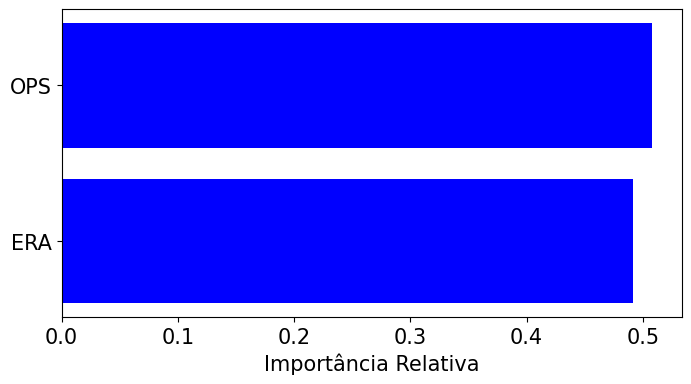

In [131]:
importances = melhor_rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,4))
#plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [melhor_features_rndf[i] for i in indices])
plt.xlabel('Importância Relativa',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Ao testar um modelo de regressão comparando as principais estatísticas de defesa e ataque é possível observar que a importâncas de ataque (potência e chegadas em base) é tão importante quanto a defesa, representada pelo ERA. 

#### Salário Arremessador x Rebatedor - Quem ganha mais?

###### É mais barato investir na defesa ou no ataque?

Para comparação de salários dos jogadores utilizo as seguintes premissas:

- Mínimo de 5 temporadas jogadas;
- Separação dos arremessadores titulares e reservas;
- Mínimo de 15 jogos iniciados pelo arremessador (uma rotação tem em média 5 starters, o que dá cerca de 30 jogos por jogador na temporada);
- Mínimo de 30 jogos para arremessadores reservas;
- Rebatedores com mínimo de 81 jogos (metade da temporada regular);
- Registros nulos de salários não foram considerados;
- Salários filtrados até 2019 devido impacto da pandemia a partir de 2020.

In [81]:
df_pitching4.loc[(df_pitching4.seasons_played>=5) &
                 #(df_pitching4.pitcher_type=='SP') &
                 (df_pitching4.G>=30) &
                 (df_pitching4.yearID<=2019) &
                 (df_pitching4.yearID>=1985)][['yearID','salary_ajs']].info() ###Avaliação da quantidade de registros nulos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8176 entries, 1 to 45589
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      8176 non-null   int64  
 1   salary_ajs  7290 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 191.6 KB


In [82]:
df_pitching_salary = df_pitching4.loc[(df_pitching4.seasons_played>=5) &
                                      #(df_pitching4.pitcher_type=='SP') &
                                      (df_pitching4.G>=20) &
                                      (df_pitching4.yearID<=2019) &
                                      (df_pitching4.yearID>=1985)].groupby(['yearID'],as_index=False)\
                                                                  .agg({'salary_ajs':'median'})

df_starter_salary = df_pitching4.loc[(df_pitching4.seasons_played>=5) &
                                     (df_pitching4.pitcher_type=='SP') &
                                     (df_pitching4.GS>=15) &
                                     (df_pitching4.yearID<=2019) &
                                     (df_pitching4.yearID>=1985)].groupby(['yearID'],as_index=False)\
                                                                 .agg({'salary_ajs':'median'})

df_reliver_salary = df_pitching4.loc[(df_pitching4.seasons_played>=5) &
                                     (df_pitching4.pitcher_type=='RP') &
                                     (df_pitching4.G>=20) &
                                     (df_pitching4.yearID<=2019) &
                                     (df_pitching4.yearID>=1985)].groupby(['yearID'],as_index=False)\
                                                                 .agg({'salary_ajs':'median'})

In [83]:
df_batting4.loc[(df_batting4.seasons_played>=5) &
                (df_batting4.G>=81) & # Jogou ao menos metade da temporada
               (df_batting4.yearID<=2019) &
               (df_batting4.yearID>=1985) &
               (df_batting4.POS!='P')][['yearID','salary_ajs']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11271 entries, 123 to 110574
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      11271 non-null  int64  
 1   salary_ajs  10533 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 264.2 KB


In [84]:
df_batting_salary = df_batting4.loc[(df_batting4.seasons_played>=5) &
                                    (df_batting4.G>=81) &
                                    (df_batting4.yearID<=2019) &
                                    (df_batting4.yearID>=1985) &
                                    (df_batting4.POS!='P')].groupby(['yearID'],as_index=False)\
                                                           .agg({'salary_ajs':'median'})

In [85]:
# Shapiro wilk - verificar se é normal
def e_normal(group):
    wval, pval = stats.shapiro(group)
    if len(group) > 5000:
        if wval <0.05: return False
        if pval < 0.05: return False
    return True
# equal variance test
def var_igual(group1,group2):
    _,pval = stats.levene(group1,group2)
    if pval<0.05: return False
    return True

# teste de hipótese
def stats_test(group1, group2):
    if e_normal(group1) and e_normal(group2):
        if var_igual(group1,group2):
            print("Realizando t-test...")
            return stats.ttest_ind(group1,group2)
        print("Relizando t-test com variancia diferente...")
        return stats.ttest_ind(group1,group2, equal_var = False)
    print("Realizando U-Test...")
    return mannwhitneyu(group1,group2)

In [86]:
lista_pvalue = []
for year in range(1985,2020):

    print('ANO: ',year)
    print((stats_test(df_batting4.loc[(df_batting4.seasons_played>=5) &
                                (df_batting4.G>=81) &
                                (df_batting4.yearID==year) &
                                ~(df_batting4.salary_ajs.isna())].salary_ajs,
               df_pitching4.loc[(df_pitching4.seasons_played>=5) &
                                #(df_pitching4.pitcher_type=='SP') &
                                (df_pitching4.G>=20) &
                                (df_pitching4.yearID==year) &
                                ~(df_pitching4.salary_ajs.isna())].salary_ajs)))
    lista_pvalue.append(str(stats_test(df_batting4.loc[(df_batting4.seasons_played>=5) &
                                 (df_batting4.G>=81) &
                                 (df_batting4.yearID==year) &
                                 ~(df_batting4.salary_ajs.isna())].salary_ajs,
                                 df_pitching4.loc[(df_pitching4.seasons_played>=5) &
                                #(df_pitching4.pitcher_type=='SP') &
                                 (df_pitching4.G>=20) &
                                 (df_pitching4.yearID==year) &
                                 ~(df_pitching4.salary_ajs.isna())].salary_ajs)).split('pvalue=')[1])
    print('\n')

ANO:  1985
Relizando t-test com variancia diferente...
Ttest_indResult(statistic=2.4465722904910447, pvalue=0.014801297961718887)
Relizando t-test com variancia diferente...


ANO:  1986
Realizando t-test...
Ttest_indResult(statistic=2.1835484096973, pvalue=0.029415762004949306)
Realizando t-test...


ANO:  1987
Realizando t-test...
Ttest_indResult(statistic=1.934890174986407, pvalue=0.05353956030026565)
Realizando t-test...


ANO:  1988
Relizando t-test com variancia diferente...
Ttest_indResult(statistic=2.57070979743642, pvalue=0.010422634319446475)
Relizando t-test com variancia diferente...


ANO:  1989
Realizando t-test...
Ttest_indResult(statistic=1.4269982757856143, pvalue=0.15415514856584817)
Realizando t-test...


ANO:  1990
Relizando t-test com variancia diferente...
Ttest_indResult(statistic=2.7178870494719884, pvalue=0.006774456122337132)
Relizando t-test com variancia diferente...


ANO:  1991
Realizando t-test...
Ttest_indResult(statistic=0.6412450953695377, pvalue=0.521

In [87]:
lista_pvalue2 = []
for x in lista_pvalue:
    x = x.split(')')[0]
    x = float(x)
    x = round(x,3)
    if(x<=0.01):
        x='**'
    elif(x<=0.05):
        x='*'
    else:
        x=''
    lista_pvalue2.append(x)

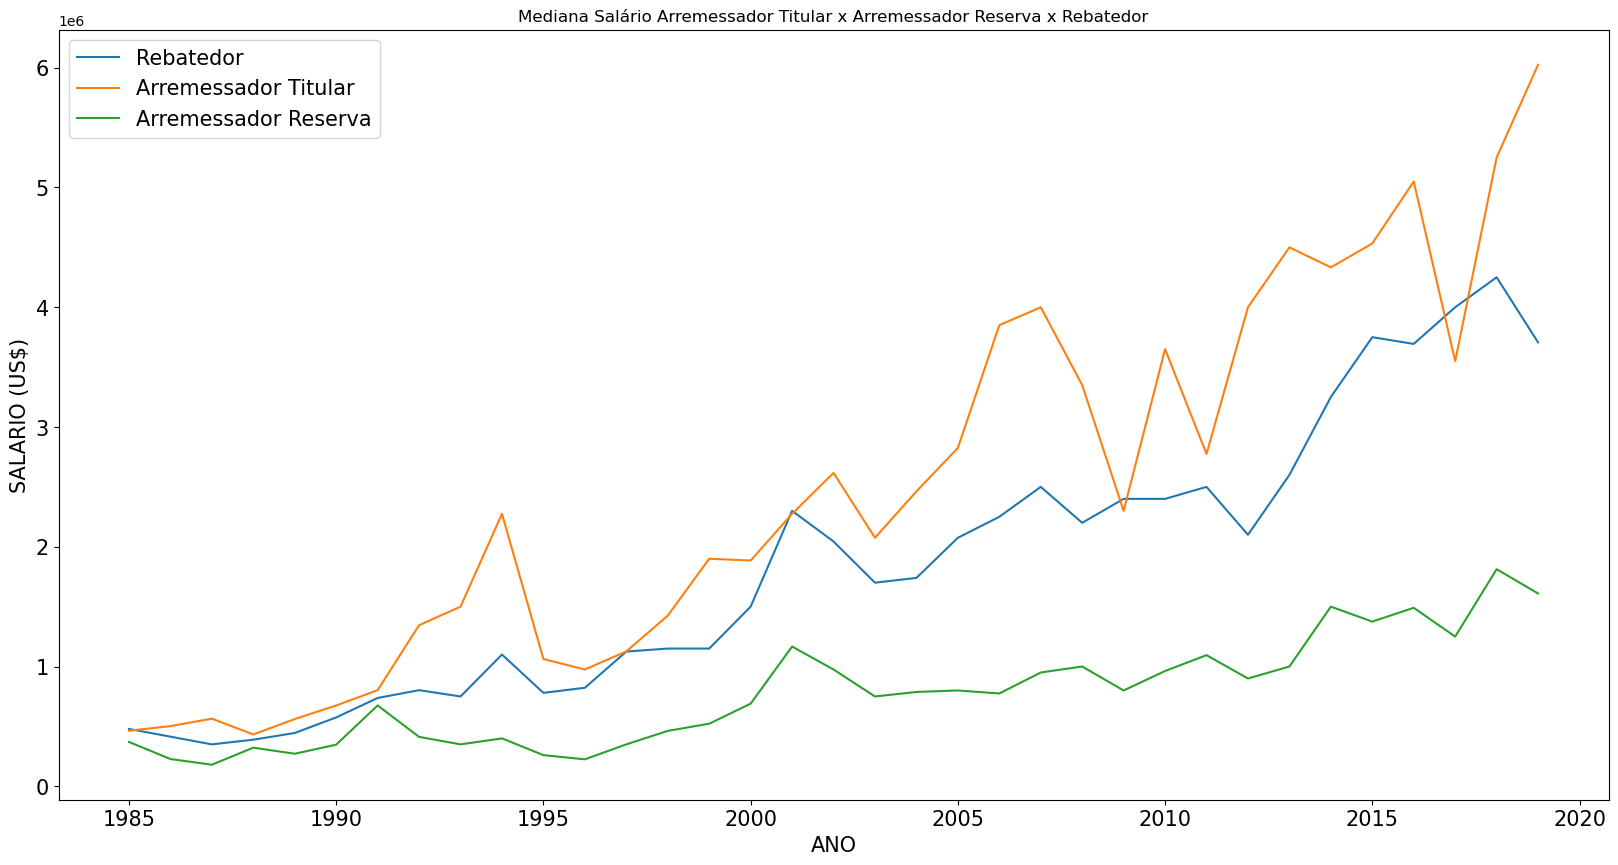

In [133]:
y='salary_ajs'
x='yearID'
plt.figure(figsize=(20,10))
sns.lineplot(data=df_batting_salary,x=x,y=y)
sns.lineplot(data=df_starter_salary,x=x,y=y)
sns.lineplot(data=df_reliver_salary,x=x,y=y)
plt.title("Mediana Salário Arremessador Titular x Arremessador Reserva x Rebatedor")
plt.legend(['Rebatedor','Arremessador Titular','Arremessador Reserva'],fontsize=15)
plt.xlabel('ANO',fontsize=15)
plt.ylabel('SALARIO (US$)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
#cont=0
#for x, y in zip(df_batting_salary[x], df_batting_salary[y]):
# the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
#    cont=cont+1
#    if(cont%3==0):
#        plt.text(x = x, # x-coordinate position of data label
#        y = y+100000, # y-coordinate position of data label, adjusted to be 150 below the data point
#        s = '${:,.0f}'.format(y), # data label, formatted to ignore decimals
#        color = 'blue') # set colour of line
#cont=0
#for x, y in zip(df_pitching_salary['yearID'], df_pitching_salary['salary']):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
#    cont=cont+1
#    if(cont%3==0):
#        plt.text(x = x, # x-coordinate position of data label
#        y = y+100000, # y-coordinate position of data label, adjusted to be 150 below the data point
#        s = '${:,.0f}'.format(y), # data label, formatted to ignore decimals
#        color = 'orange') # set colour of line"""

É possível observar como os arremessadores titulares possuem salários maiores, seguido dos jogadores de posição (rebatedores) e depois os arremessadores reservas que tem uma importância bastante relevante nos times.

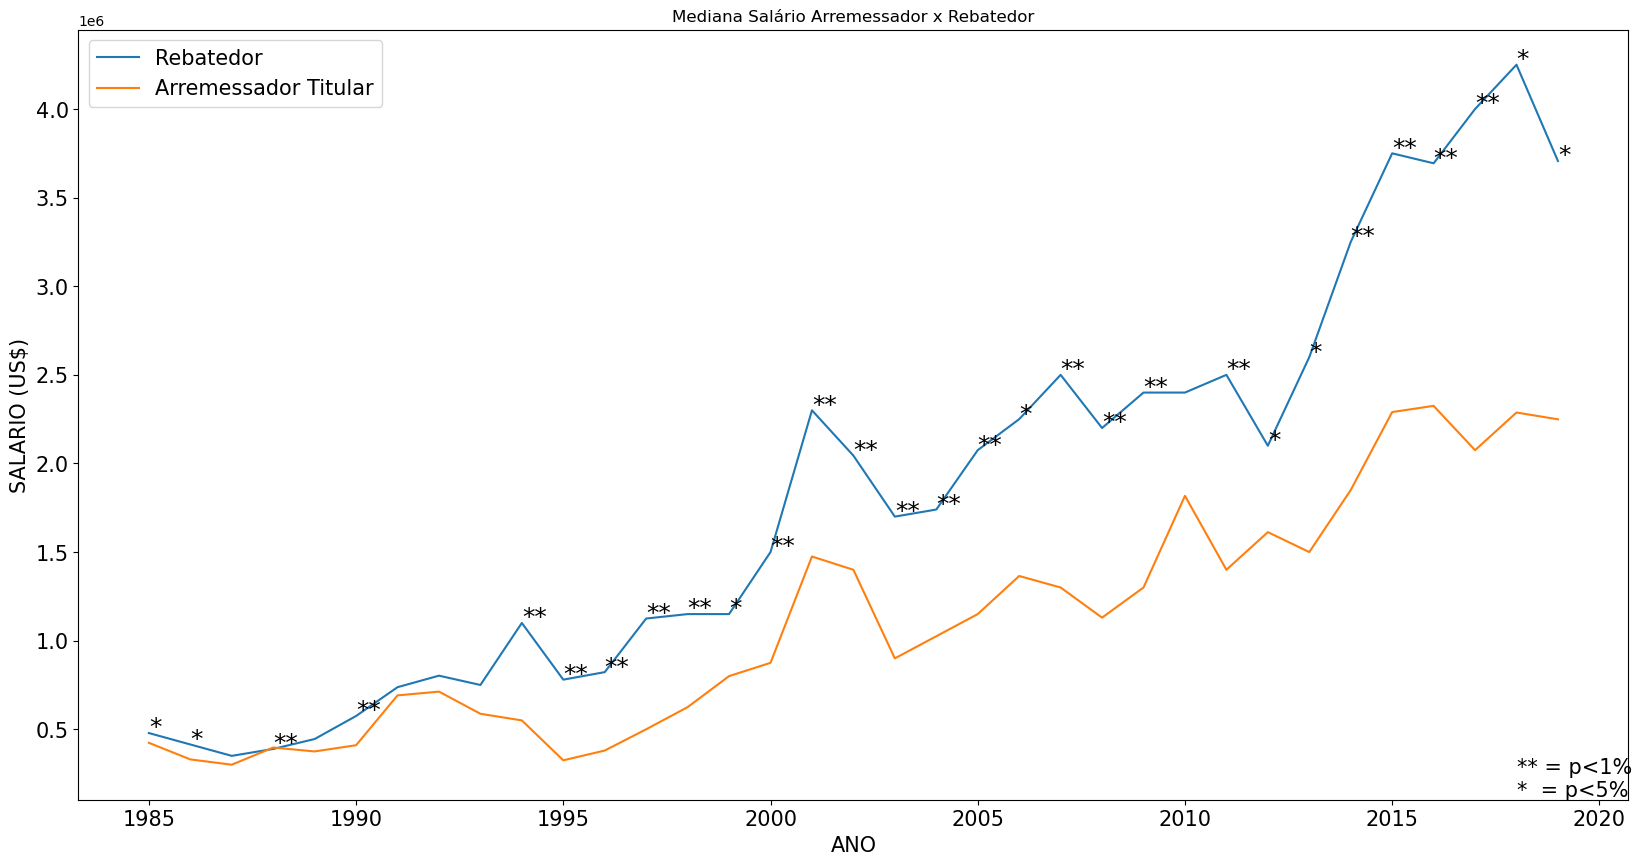

In [136]:
y='salary_ajs'
x='yearID'
plt.figure(figsize=(20,10))
sns.lineplot(data=df_batting_salary,x=x,y=y)
sns.lineplot(data=df_pitching_salary,x=x,y=y)
plt.title("Mediana Salário Arremessador x Rebatedor")
plt.legend(['Rebatedor','Arremessador Titular'],fontsize=15)
plt.xlabel('ANO',fontsize=15)
plt.ylabel('SALARIO (US$)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#cont=0
for x, y, z in zip(df_batting_salary[x], df_batting_salary[y],lista_pvalue2):
# the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
#    cont=cont+1
    plt.text(x = x, # x-coordinate position of data label
    y = y-10000, # y-coordinate position of data label, adjusted to be 150 below the data point
    s = z, # data label, formatted to ignore decimals
    color = 'black',
    fontsize=18) # set colour of line
    
plt.text(x=2018,y=120000,s='** = p<1%\n*  = p<5%',fontsize=15)
plt.show()

Ao verificar a mediana de salários entre rebatedores e arremessadores no geral, os rebatedores ganham mais. Cada time tem 9 rebatedores titulares, 5 arremessadores titulares e cerca de 6 arremessadores reservas.

In [84]:
df_salarios_ano = df_batting_salary.rename(columns={'salary_ajs':'salary_batting'})\
                                   .merge(df_pitching_salary\
                                   .rename(columns={'salary_ajs':'salary_pitcher'}),on=['yearID'])\
                                   .merge(df_starter_salary\
                                   .rename(columns={'salary_ajs':'salary_starter'}),on=['yearID'])\
                                   .merge(df_reliver_salary\
                                   .rename(columns={'salary_ajs':'salary_reliver'}),on=['yearID'])

df_salarios_ano['diferenca_salario_batter_SP'] = df_salarios_ano.salary_batting/df_salarios_ano.salary_starter-1
df_salarios_ano['diferenca_salario_batter_RP'] = df_salarios_ano.salary_batting/df_salarios_ano.salary_reliver-1
df_salarios_ano['diferenca_salario_SP_RP'] = df_salarios_ano.salary_starter/df_salarios_ano.salary_reliver-1
df_salarios_ano['diferenca_salario_batter_pitcher'] = df_salarios_ano.salary_batting/df_salarios_ano.salary_pitcher-1

In [85]:
df_salarios_ano.tail(5)

yearID  salary_batting  salary_pitcher  salary_starter  salary_reliver  \
30    2015  3750000.000000  2290000.000000  4532500.000000  1375000.000000   
31    2016  3693750.000000  2325000.000000  5050000.000000  1490314.000000   
32    2017  4000000.000000  2075000.000000  3550000.000000  1250000.000000   
33    2018  4250000.000000  2287500.000000  5250000.000000  1812500.000000   
34    2019  3706500.000000  2249000.000000  6025000.000000  1610000.000000   

    diferenca_salario_batter_SP  diferenca_salario_batter_RP  \
30                    -0.172642                     1.727273   
31                    -0.268564                     1.478505   
32                     0.126761                     2.200000   
33                    -0.190476                     1.344828   
34                    -0.384813                     1.302174   

    diferenca_salario_SP_RP  diferenca_salario_batter_pitcher  
30                 2.296364                          0.637555  
31                 2.388548                          0.588710  
32                 1.840000                          0.927711  
33                 1.896552                          0.857923  
34                 2.742236                          0.648066

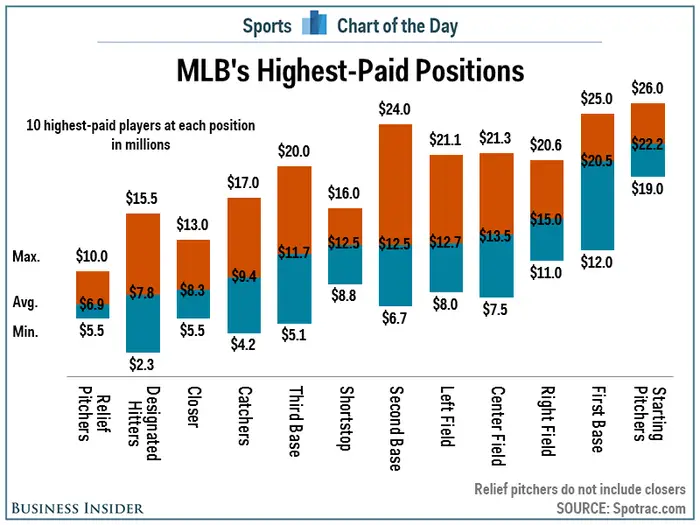

Fonte: https://www.businessinsider.com/chart-mlbs-highest-paid-positions-2014-7

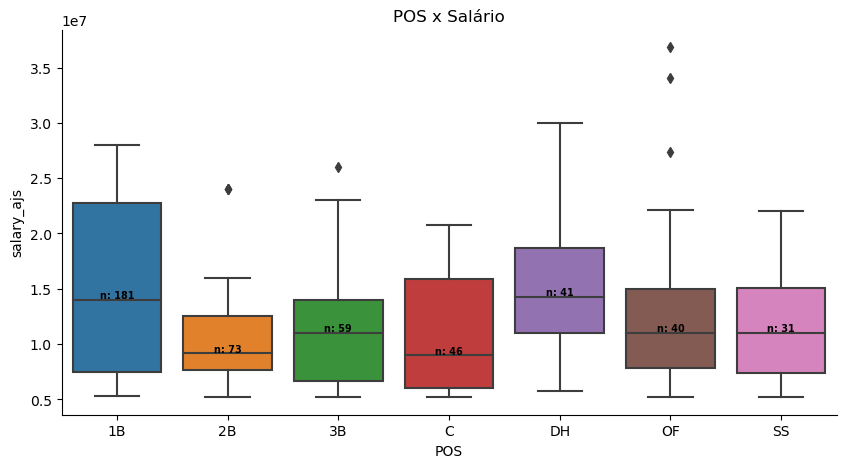

In [139]:
df_batting41 = df_batting4.loc[(df_batting4.seasons_played>=5) &
                                (df_batting4.G>=81) &
                                (df_batting4.yearID<=2019) &
                                (df_batting4.yearID>=2015) &
                                (df_batting4.POS!='P') &
                                (df_batting4.salary_ajs>=df_batting4.salary_ajs.quantile(0.90))]

df_batting41 = df_batting41.sort_values(['POS'])
colunas = ['salary_ajs']
for coluna in colunas:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x='POS',y=coluna,data=df_batting41,showfliers=True)
    plt.title(f"POS x Salário")
    
    # Calculate number of obs per group & median to position labels
    medians = df_batting41.groupby(['POS'])[coluna].median().values
    nobs = df_batting41['POS'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] + medians[tick]*0.01,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='black',
                weight='semibold'
               )
    sns.despine()
    plt.show()

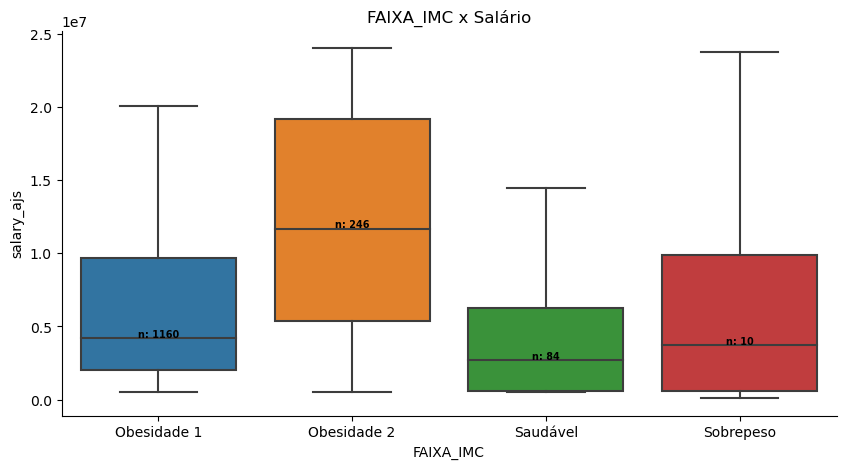

In [87]:
df_batting42 = df_batting4.loc[(df_batting4.seasons_played>=5) &
                                (df_batting4.G>=81) &
                                (df_batting4.yearID<=2019) &
                                (df_batting4.yearID>=2015) &
                                (df_batting4.POS!='P')]
df_batting42 = df_batting42.sort_values(['FAIXA_IMC'])
colunas = ['salary_ajs']
for coluna in colunas:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x='FAIXA_IMC',y=coluna,data=df_batting42,showfliers=False)
    plt.title(f"FAIXA_IMC x Salário")
    
    # Calculate number of obs per group & median to position labels
    medians = df_batting42.groupby(['FAIXA_IMC'])[coluna].median().values
    nobs = df_batting42['FAIXA_IMC'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] + medians[tick]*0.01,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='black',
                weight='semibold'
               )
    sns.despine()
    plt.show()

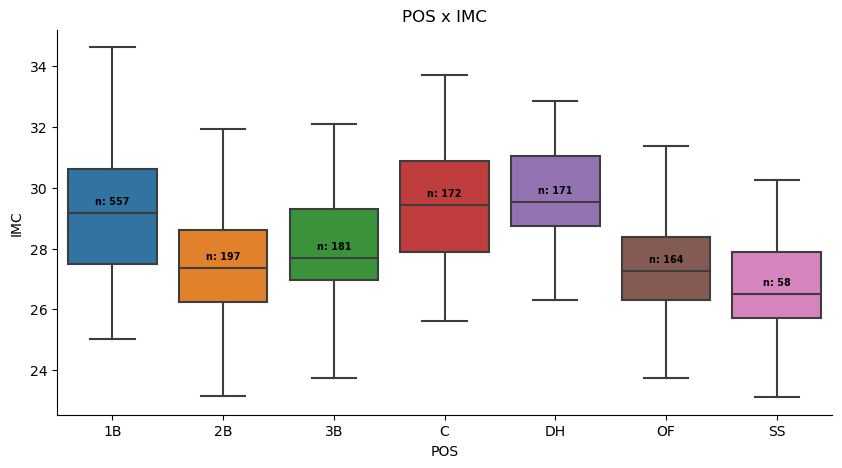

In [141]:
df_batting42 = df_batting4.loc[(df_batting4.seasons_played>=5) &
                                (df_batting4.G>=81) &
                                (df_batting4.yearID<=2019) &
                                (df_batting4.yearID>=2015) &
                                (df_batting4.POS!='P')]
df_batting42 = df_batting42.sort_values(['POS'])
colunas = ['IMC']
for coluna in colunas:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x='POS',y=coluna,data=df_batting42,showfliers=False)
    plt.title(f"POS x IMC")
    
    # Calculate number of obs per group & median to position labels
    medians = df_batting42.groupby(['POS'])[coluna].median().values
    nobs = df_batting42['POS'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] + medians[tick]*0.01,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='black',
                weight='semibold'
               )
    sns.despine()
    plt.show()

In [103]:
#y='salary_ajs'
#x='yearID'
#plt.figure(figsize=(30,20))
#for pos in df_batting4.POS.unique():
#    sns.lineplot(data=df_batting4.loc[(df_batting4.seasons_played>=5) &
#                                      (df_batting4.G>=81) &
#                                      (df_batting4.yearID<=2019) &
#                                      (df_batting4.yearID>=1985) &
#                                      (df_batting4.POS!='P') &
#                                      (df_batting4.POS!=pos)].groupby(['yearID'],as_index=False)\
#                                 .agg({'salary_ajs':'median'}),x=x,y=y)
#plt.title("Mediana Salário por Posição")
#plt.legend(df_batting4.POS.unique())
#plt.xlabel('ANO')
#plt.ylabel('SALARIO (US$)');

#### Quanto custa um rebatedor de potência x rebatedor que chega mais em base?

In [143]:
df_batting6 = df_batting4.loc[(df_batting4.yearID>=2015) & ### período mais recente para comparação de salário
                              (df_batting4.yearID<=2019) & ### máximo base salário
                              ~(df_batting4.salary_ajs.isna()) & ### retirando registros nulos de salário
                              (df_batting4.G>=81)]   ### Metade da temporada jogada

In [144]:
df_batting6[['R']].describe()

R
count 1236.000000
mean    58.661812
std     24.952954
min      0.000000
25%     39.000000
50%     56.500000
75%     76.000000
max    137.000000

In [145]:
df_batting6['salary_range'] = np.where(df_batting6.salary_ajs<=df_batting6.salary_ajs.quantile(0.25),'Range 1 - 100K-572K',
                              np.where(df_batting6.salary_ajs<=df_batting6.salary_ajs.quantile(0.5),'Range 2 - 573K-3.3M',
                              np.where(df_batting6.salary_ajs<=df_batting6.salary_ajs.quantile(0.75),'Range 3 - 3.4M-8.5M',
                                       'Range 4 - 8.6M-37M')))

df_batting6['R_range'] = np.where(df_batting6.R<=df_batting6.R.quantile(0.25),'Range 1 - 0-38',
                         np.where(df_batting6.R<=df_batting6.R.quantile(0.5),'Range 2 - 39-56',
                         np.where(df_batting6.R<=df_batting6.R.quantile(0.75),'Range 3 - 57-75','Range 4 - 76-137')))

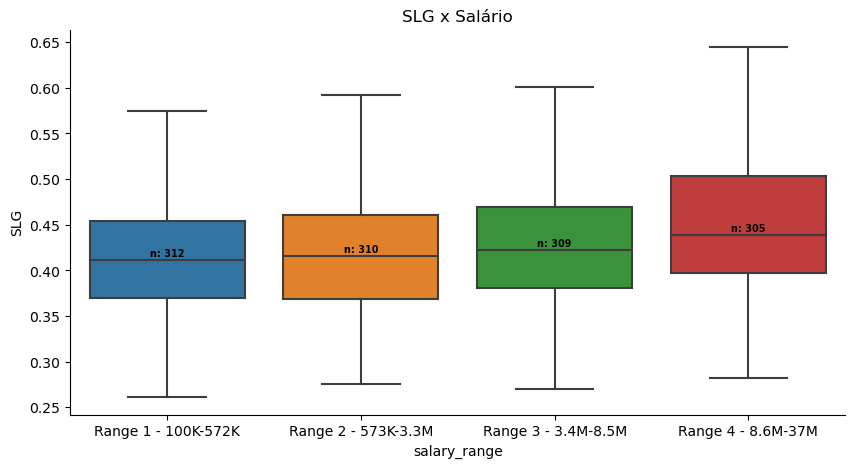

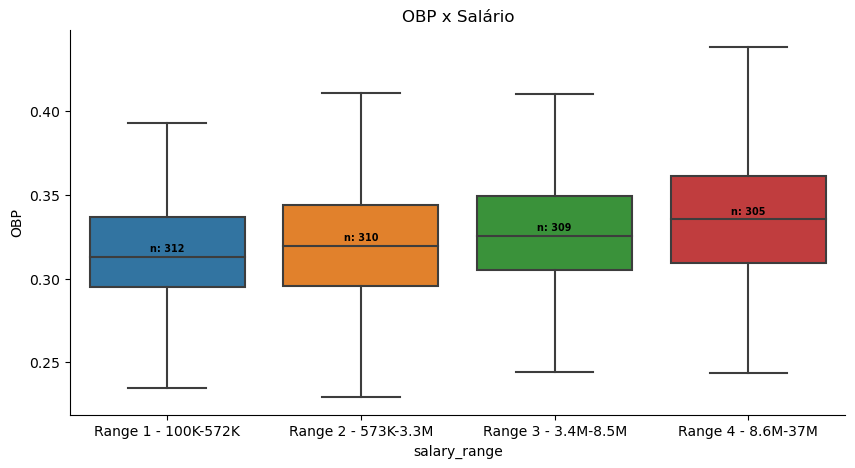

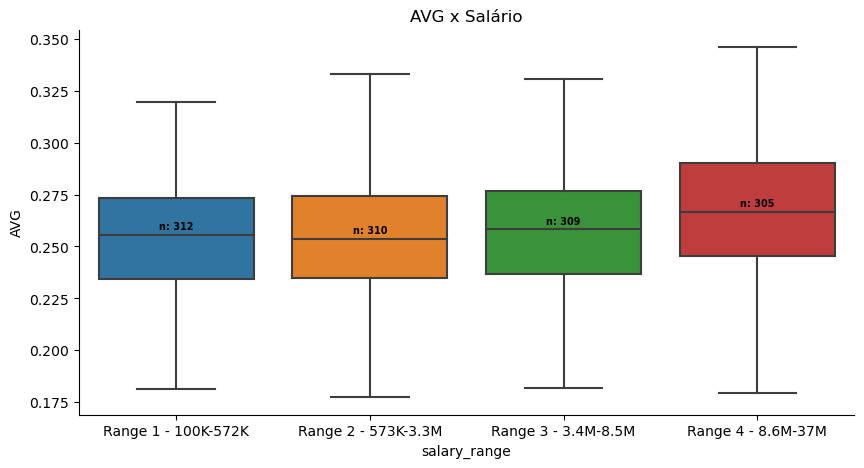

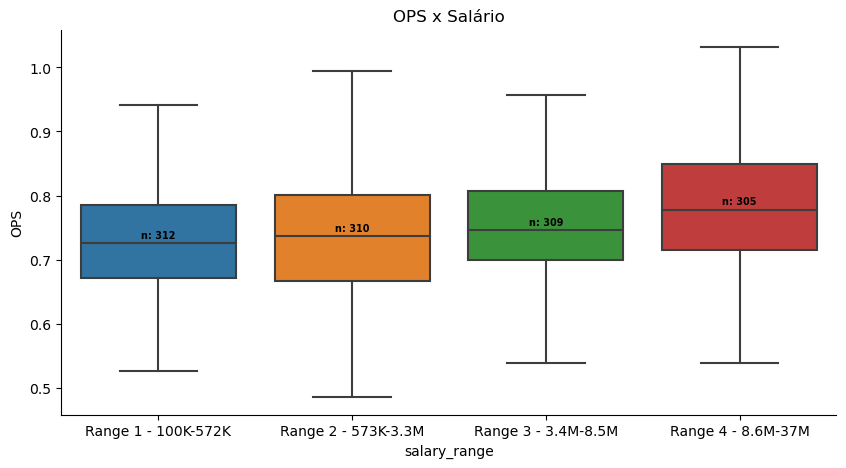

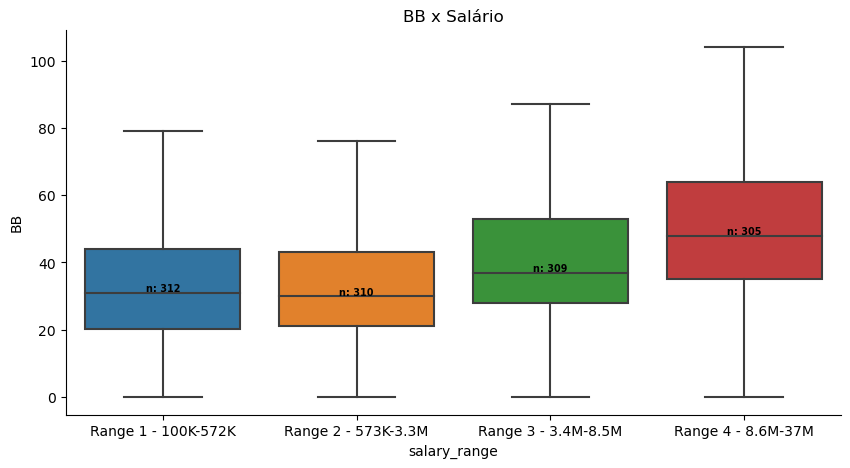

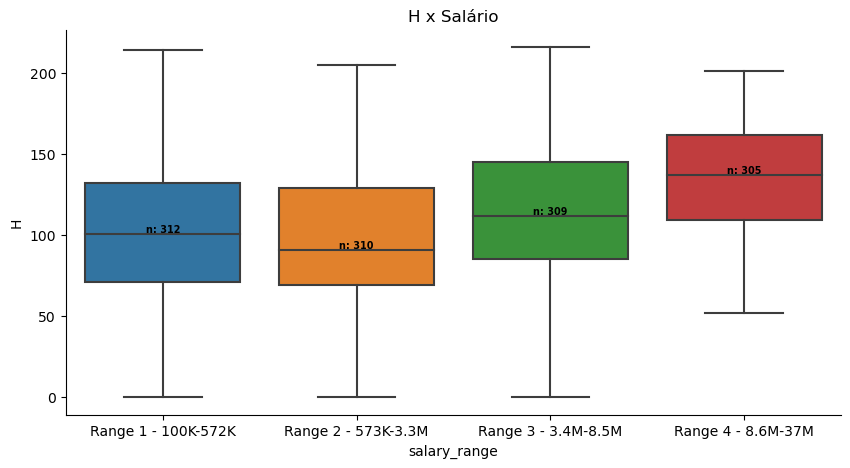

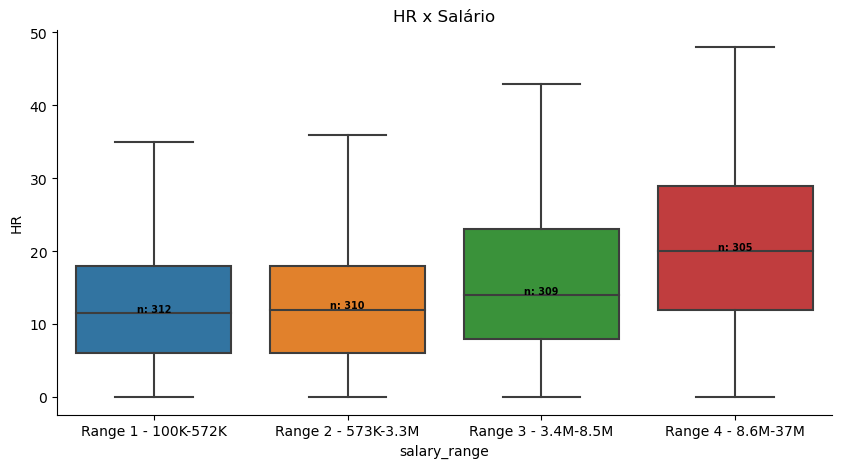

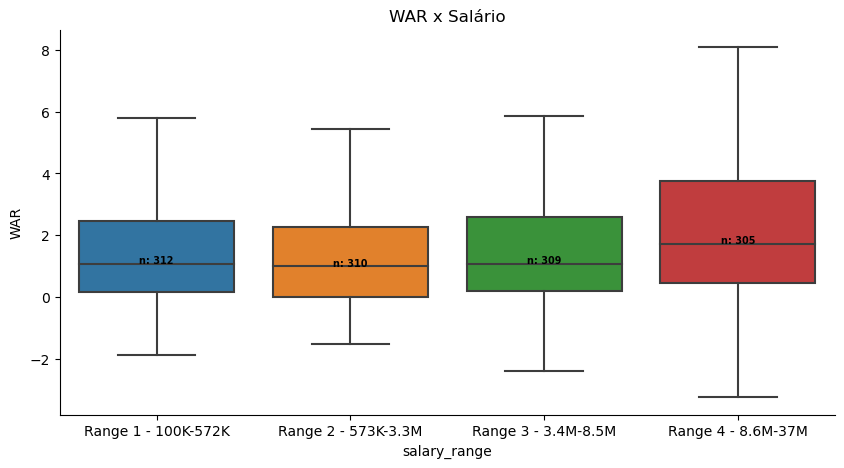

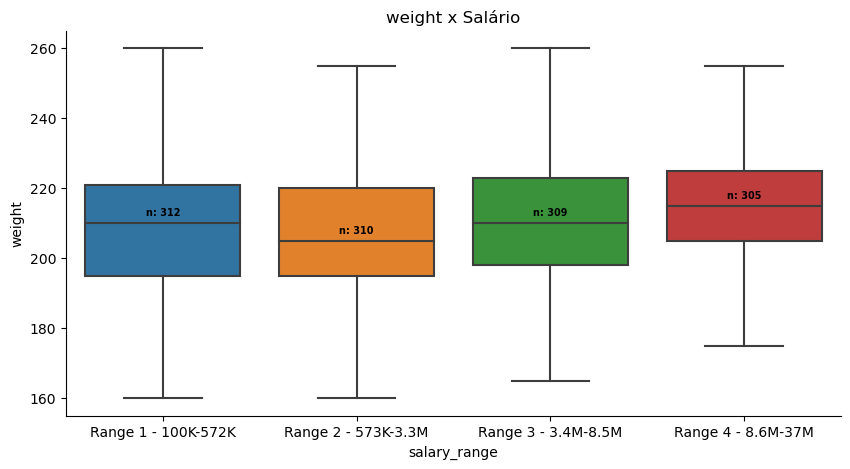

In [147]:
df_batting6 = df_batting6.sort_values(['salary_range'])
colunas = ['SLG','OBP','AVG','OPS','BB','H','HR','WAR','weight']
for coluna in colunas:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x='salary_range',y=coluna,data=df_batting6,showfliers=False)
    plt.title(f"{coluna} x Salário")
    
    # Calculate number of obs per group & median to position labels
    medians = df_batting6.groupby(['salary_range'])[coluna].median().values
    nobs = df_batting6['salary_range'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] + medians[tick]*0.01,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='black',
                weight='semibold'
               )
    sns.despine()
    plt.show()

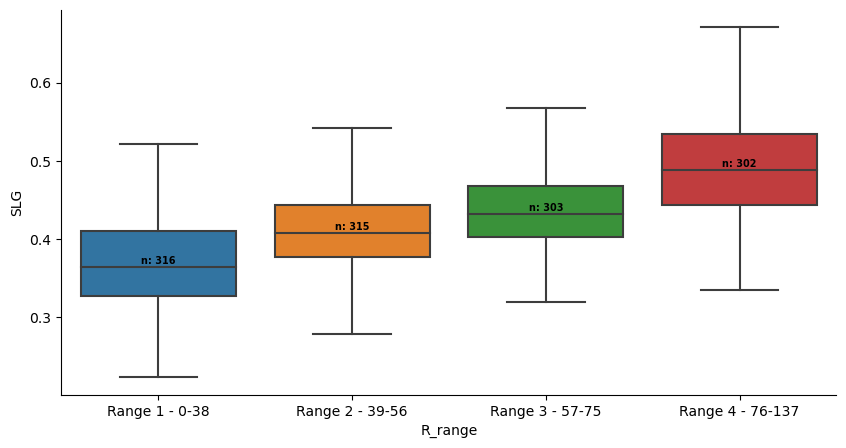

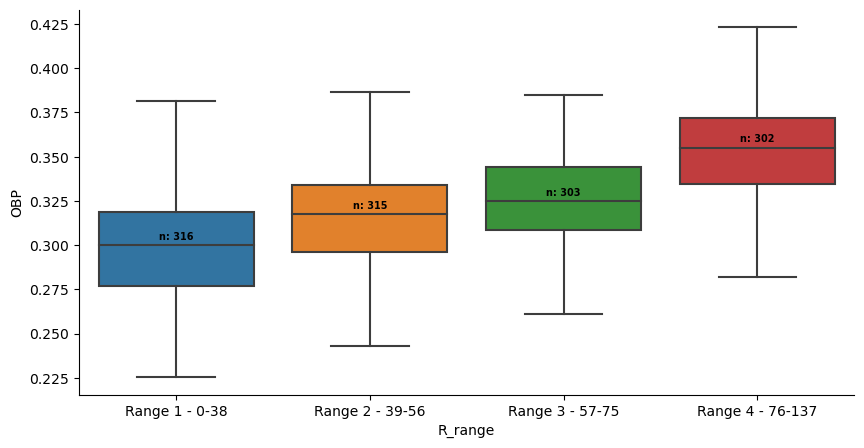

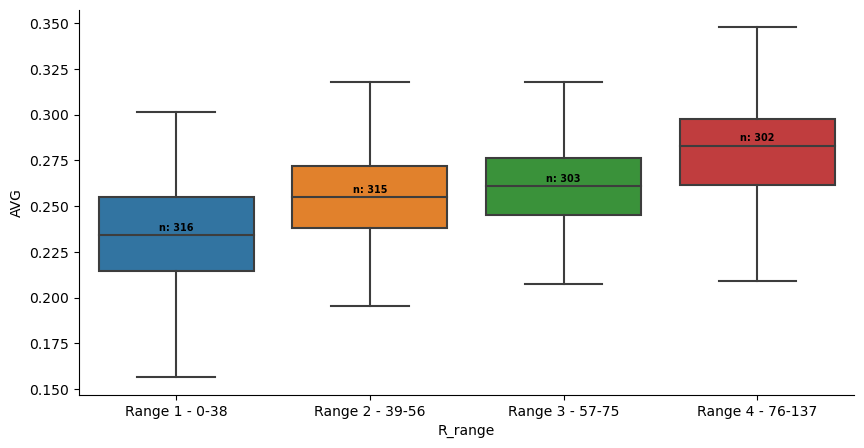

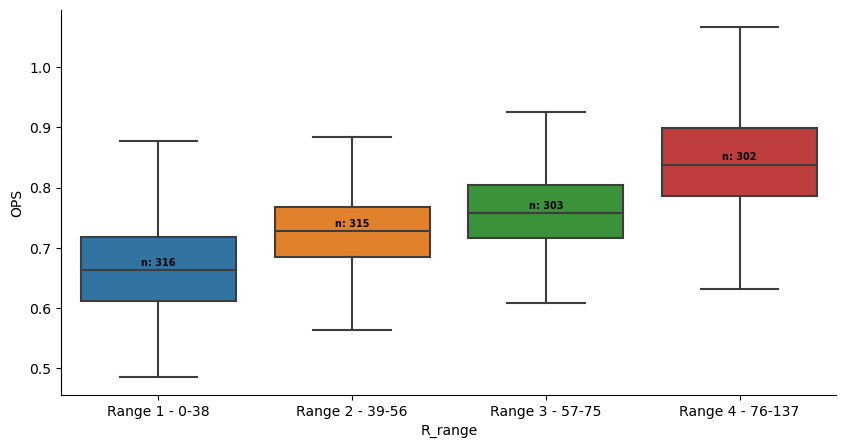

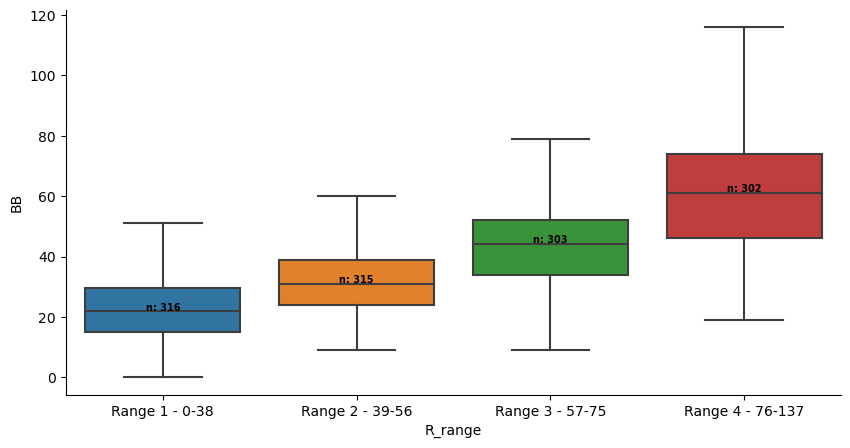

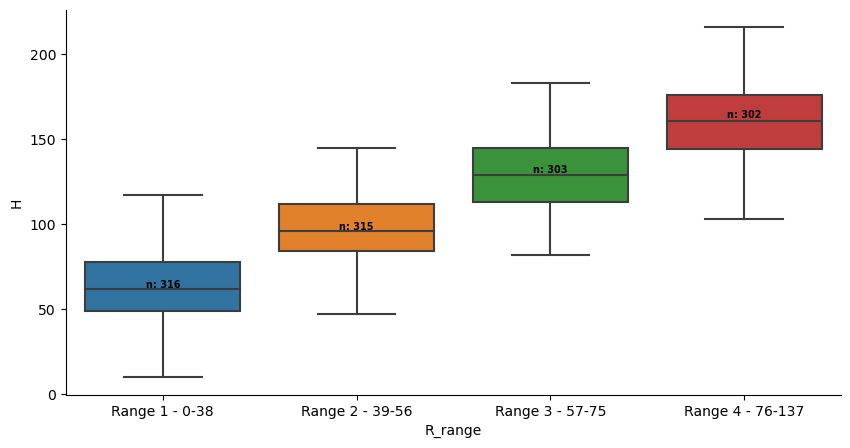

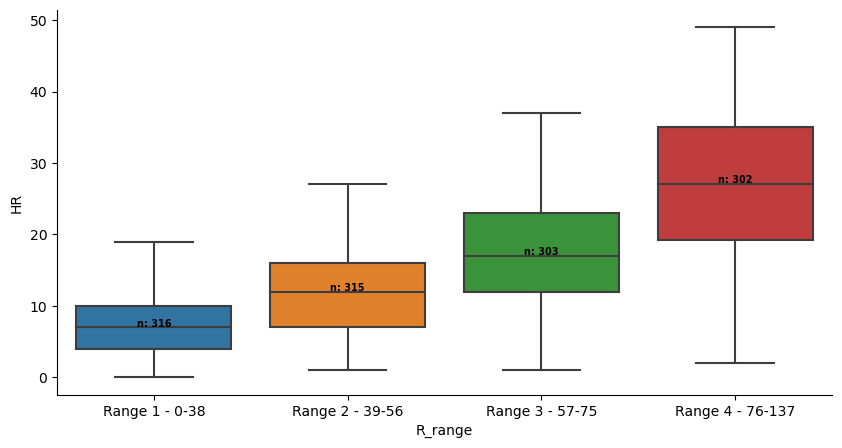

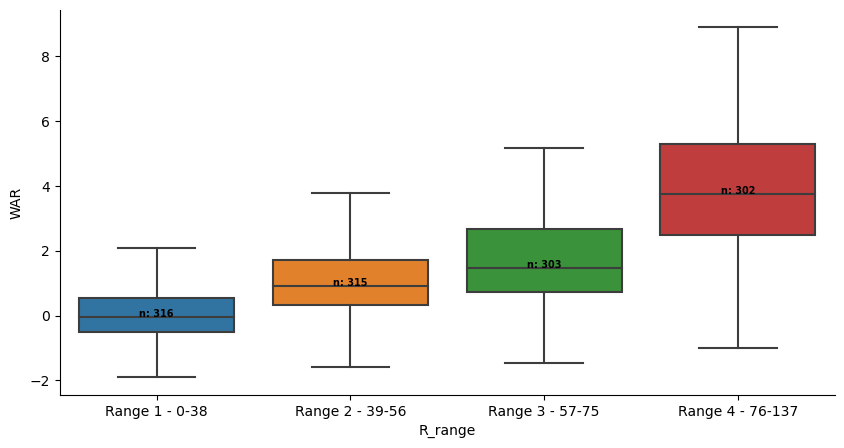

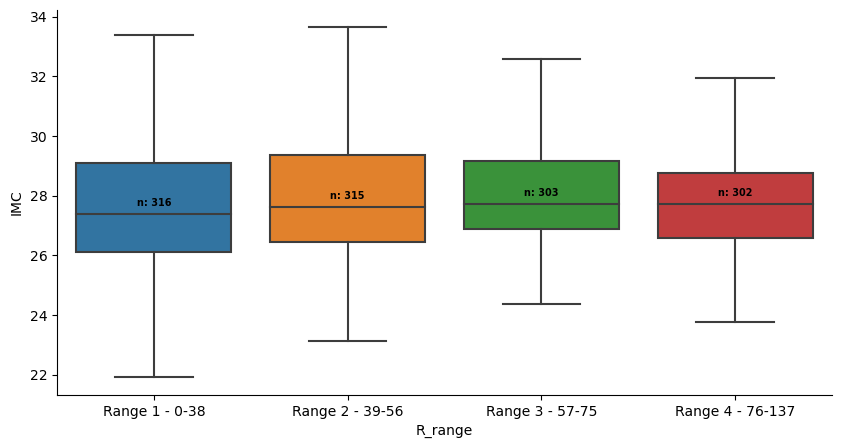

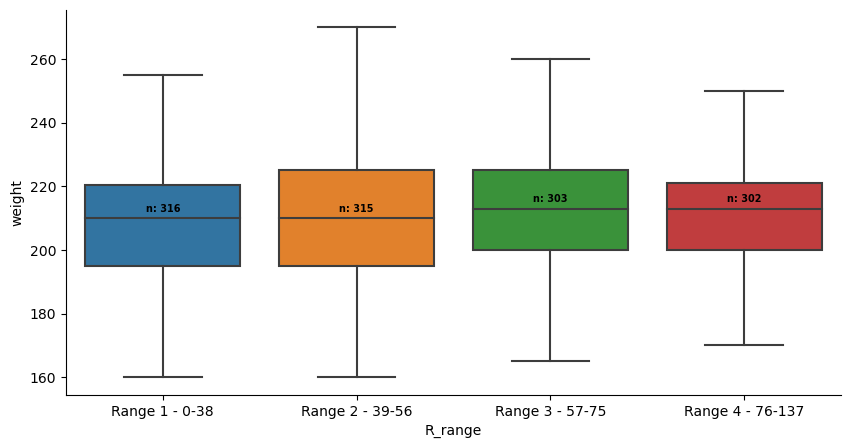

In [148]:
df_batting6 = df_batting6.sort_values(['R_range'])
colunas = ['SLG','OBP','AVG','OPS','BB','H','HR','WAR','IMC','weight']
for coluna in colunas:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x='R_range',y=coluna,data=df_batting6,showfliers=False)
    #plt.title(f"{coluna} x Corridas")
    
    # Calculate number of obs per group & median to position labels
    medians = df_batting6.groupby(['R_range'])[coluna].median().values
    nobs = df_batting6['R_range'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] + medians[tick]*0.01,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='black',
                weight='semibold'
               )
    sns.despine()
    plt.show()

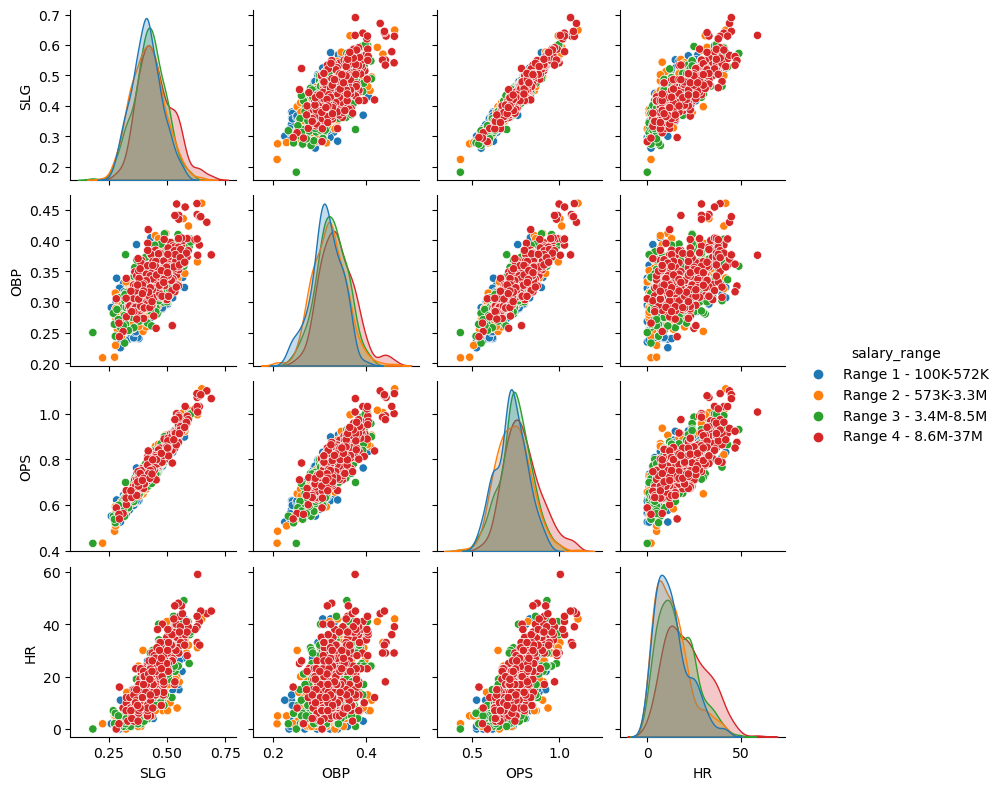

In [149]:
colunas = ['SLG','OBP','OPS','HR','salary_range']
df_batting6 = df_batting6.sort_values(['salary_range'])
sns.pairplot(df_batting6[colunas],hue='salary_range',height=2);

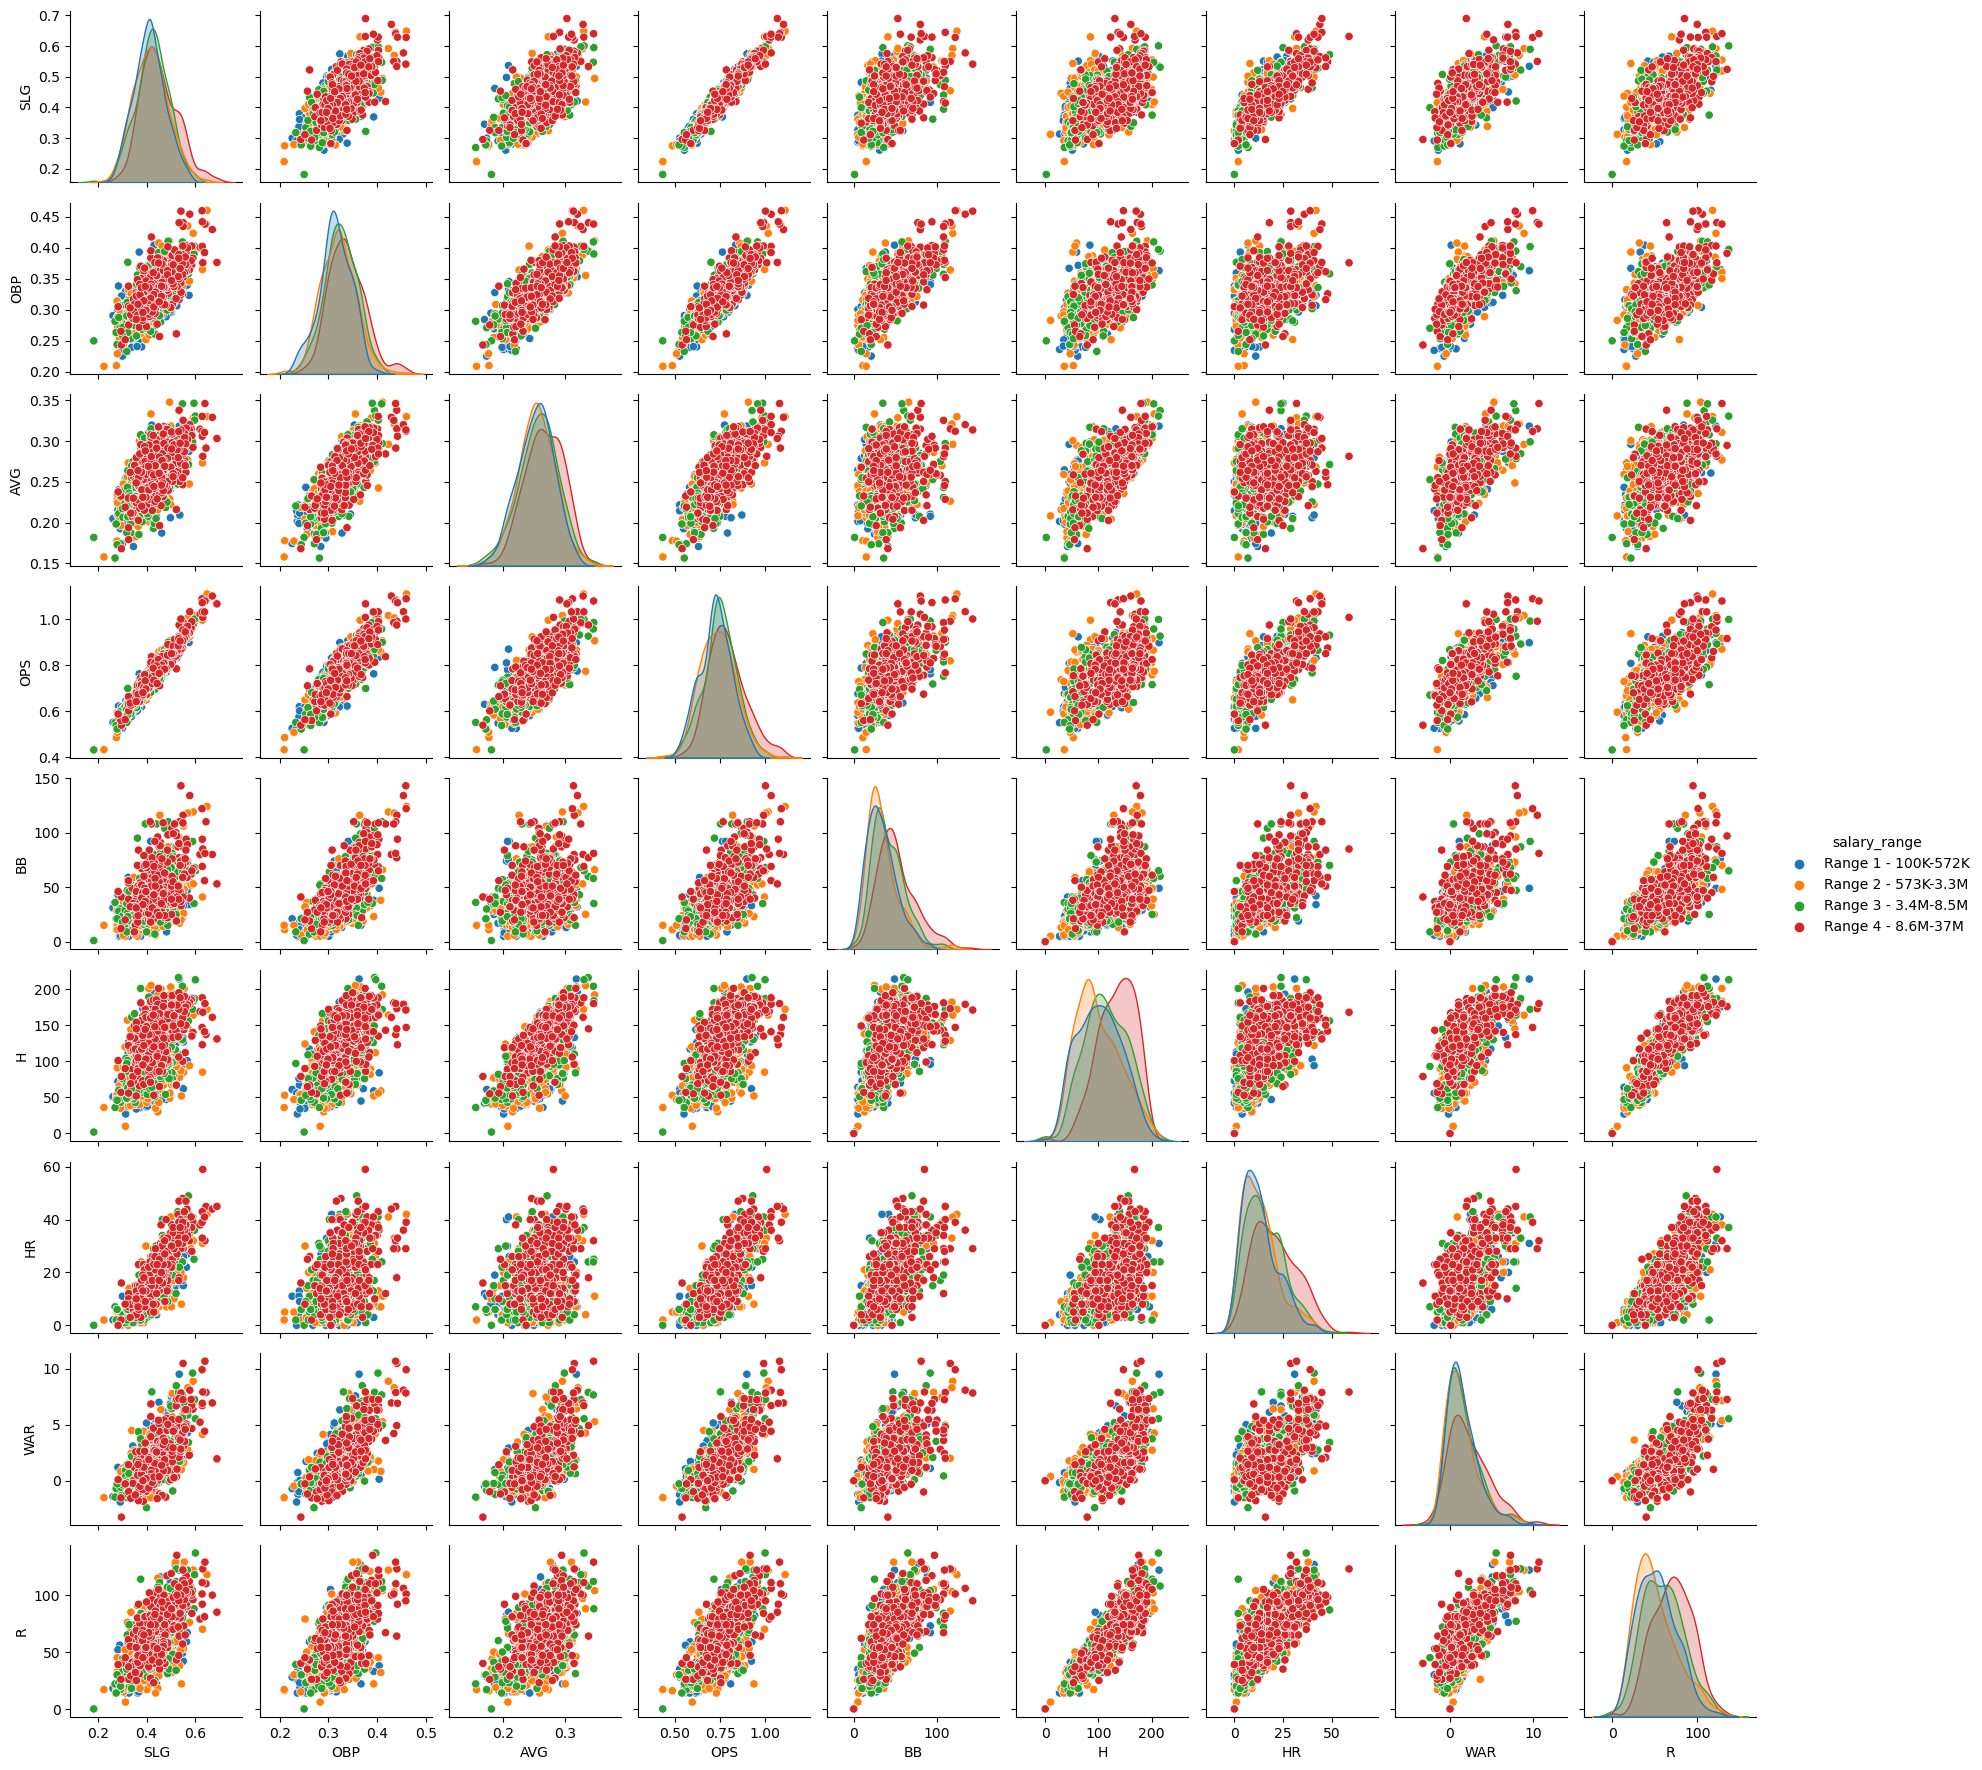

In [150]:
colunas = ['SLG','OBP','AVG','OPS','BB','H','HR','WAR','R','salary_range']
df_batting6 = df_batting6.sort_values(['salary_range'])
sns.pairplot(df_batting6[colunas],hue='salary_range',height=2);

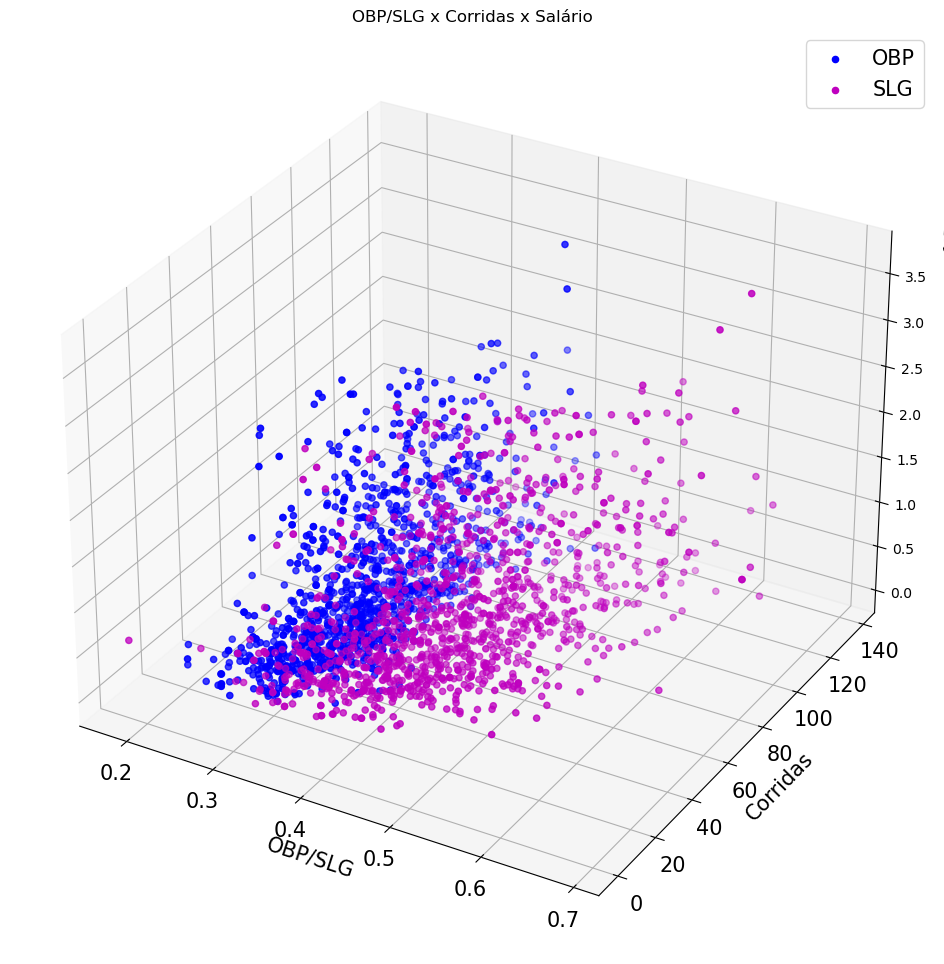

In [154]:
y='R'
x='OBP'
x2='SLG'
z = 'salary_ajs'
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_batting6[x], df_batting6[y],df_batting6[z],color='b')
ax.scatter(df_batting6[x2], df_batting6[y],df_batting6[z],color='m')
plt.title("OBP/SLG x Corridas x Salário")
plt.legend(['OBP','SLG'],fontsize=15)
plt.xlabel('OBP/SLG',fontsize=15)
plt.ylabel('Corridas',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.zlabel('Salário')
plt.show();

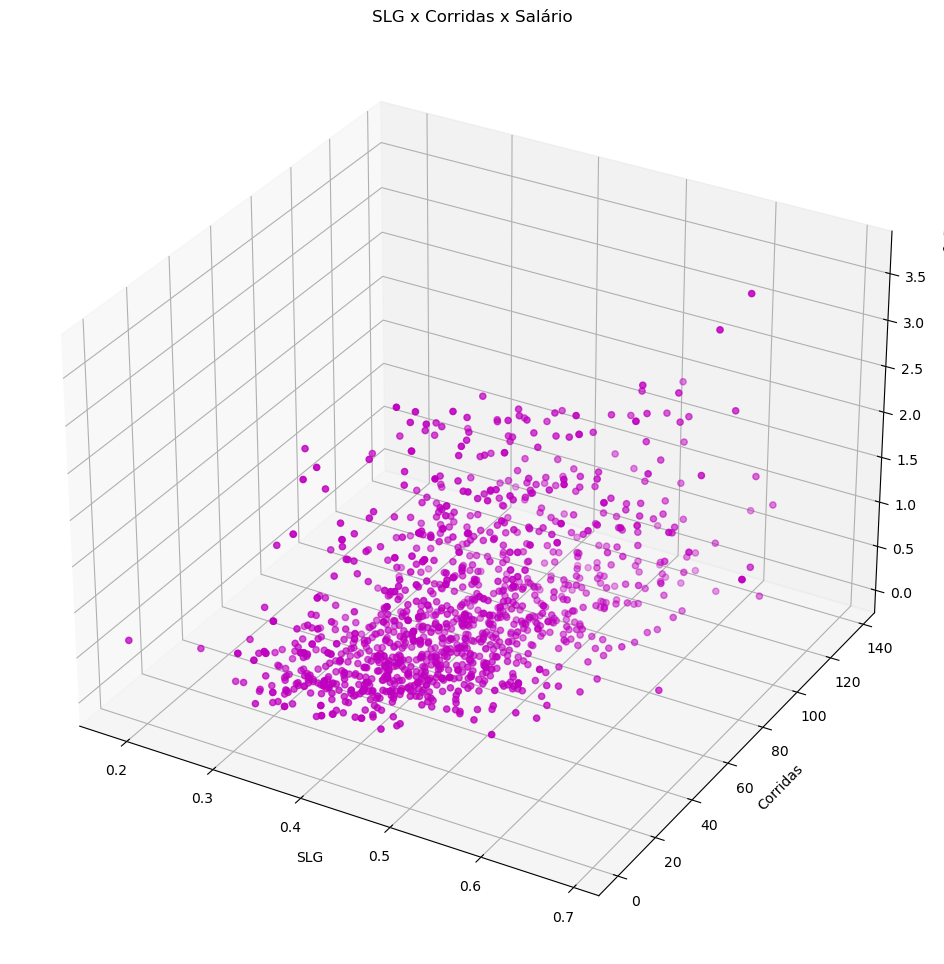

In [98]:
y='R'
x='SLG'
z = 'salary_ajs'
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_batting6[x], df_batting6[y],df_batting6[z],color='m')
plt.title("SLG x Corridas x Salário")
plt.xlabel('SLG')
plt.ylabel('Corridas')
plt.show();

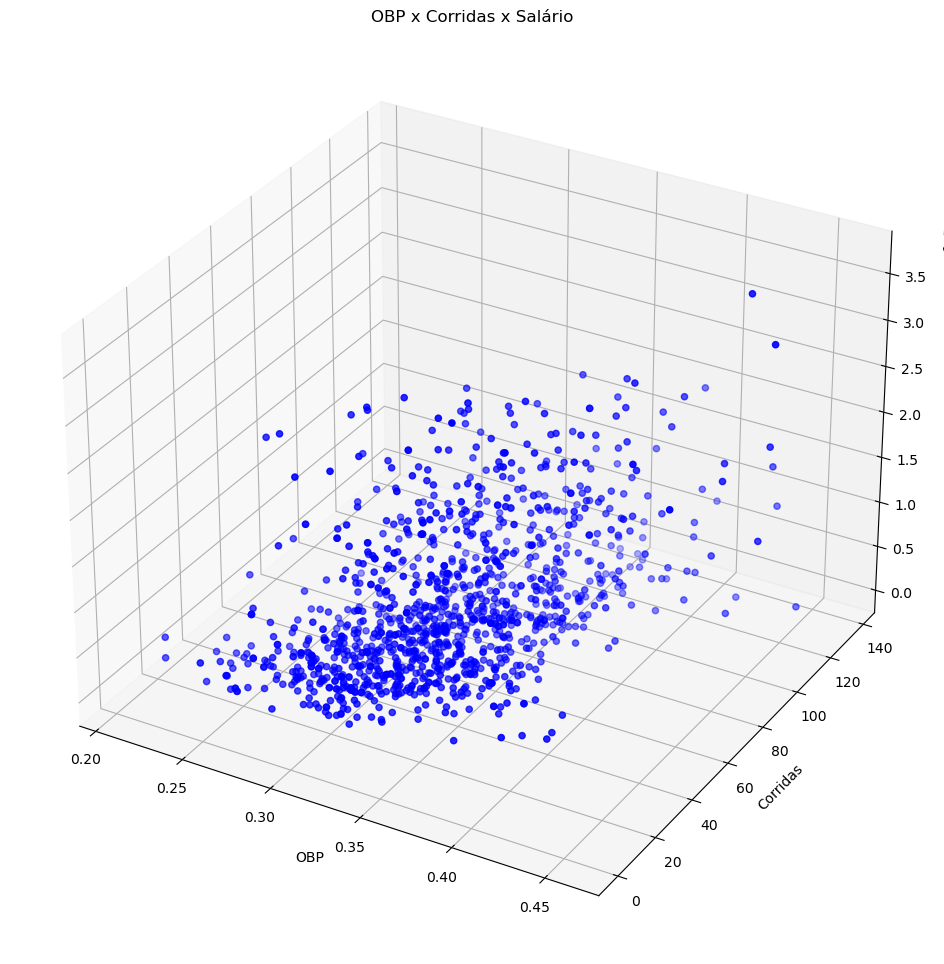

In [99]:
y='R'
x='OBP'
z = 'salary_ajs'
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_batting6[x], df_batting6[y],df_batting6[z],color='b')
plt.title("OBP x Corridas x Salário")
plt.xlabel('OBP')
plt.ylabel('Corridas')
plt.show();

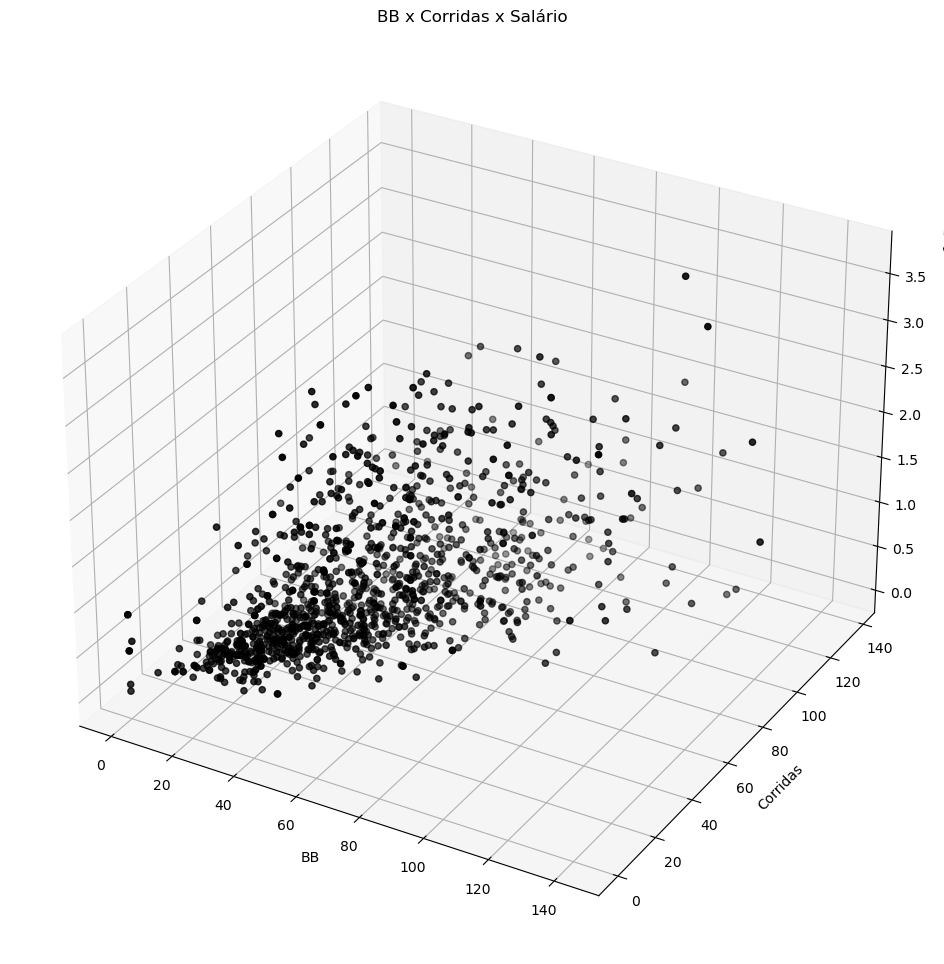

In [100]:
y='R'
x='BB'
z = 'salary_ajs'
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_batting6[x], df_batting6[y],df_batting6[z],color='black')
plt.title("BB x Corridas x Salário")
plt.xlabel('BB')
plt.ylabel('Corridas')
plt.show();

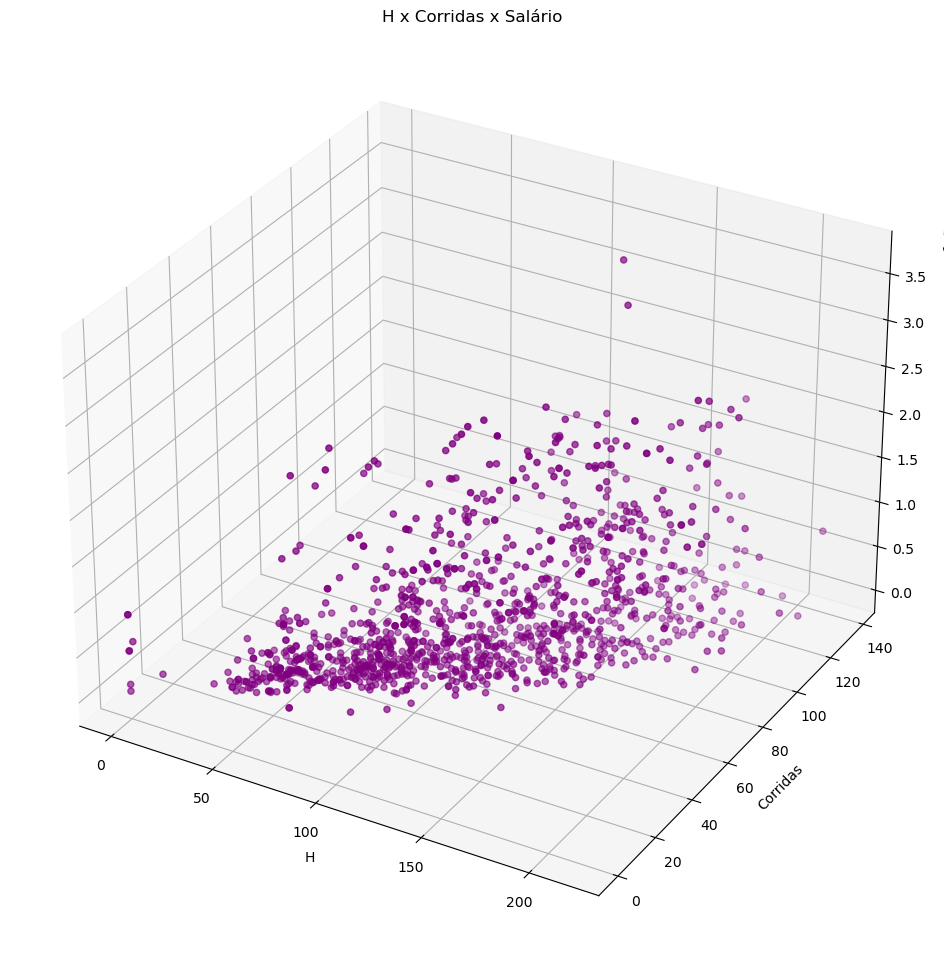

In [101]:
y='R'
x='H'
z = 'salary_ajs'
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_batting6[x], df_batting6[y],df_batting6[z],color='purple')
plt.title("H x Corridas x Salário")
plt.xlabel('H')
plt.ylabel('Corridas')
plt.show();

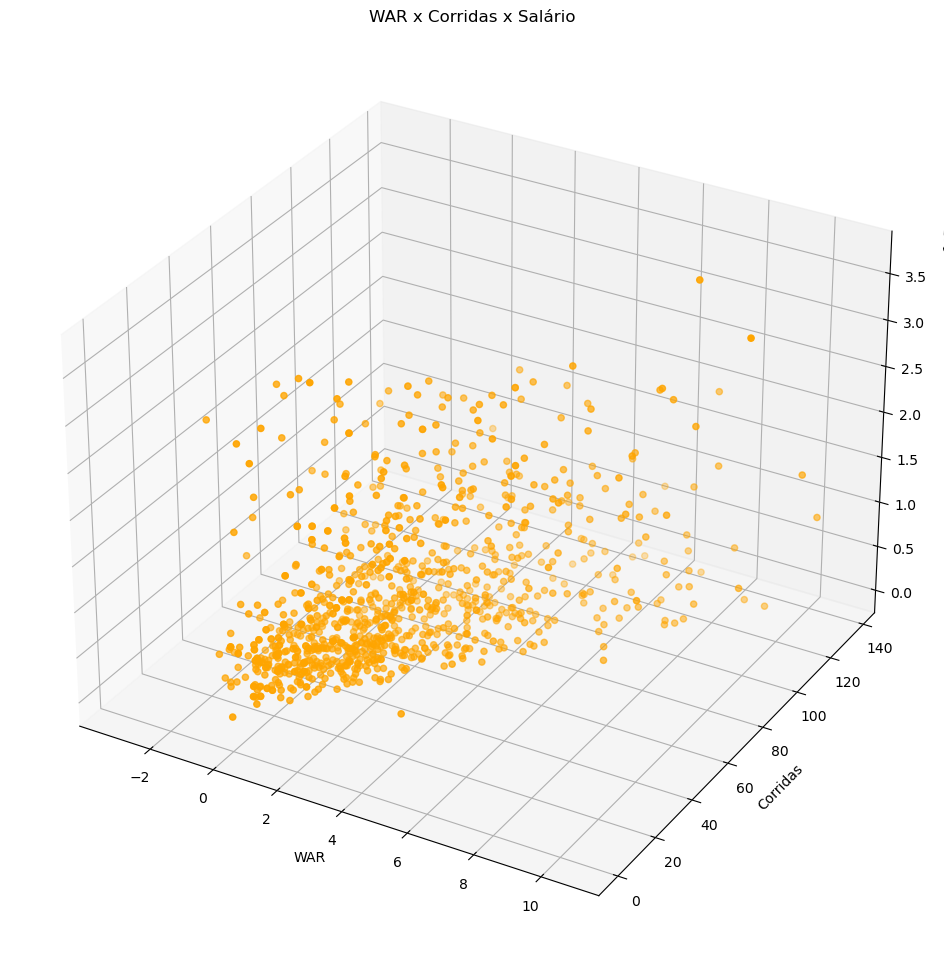

In [104]:
y='R'
x='WAR'
z = 'salary_ajs'
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_batting6[x], df_batting6[y],df_batting6[z],color='orange')
plt.title("WAR x Corridas x Salário")
plt.xlabel('WAR')
plt.ylabel('Corridas')
plt.show();

### Quanto custa cada vitória?

In [156]:
### Rebatedores

df_batting21 = df_batting2.merge(df_salaries,on=['playerID','yearID','teamID','lgID'],how='left')

df_batting21['salary_ajs'] = np.where(df_batting21.salary.isna(),df_batting21.salary_war,df_batting21.salary)

df_batting22 = df_batting21.groupby(['teamID','yearID'],as_index=False).agg({'salary_ajs':'sum'})
df_batting22.rename(columns={'salary_ajs':'salary_batting'},inplace=True)

### Arremessadores

df_pitching21 = df_pitching2.merge(df_salaries,on=['playerID','yearID','teamID','lgID'],how='left')

df_pitching21['salary_ajs'] = np.where(df_pitching21.salary.isna(),df_pitching21.salary_war,df_pitching21.salary)

df_pitching22 = df_pitching21.groupby(['teamID','yearID'],as_index=False).agg({'salary_ajs':'sum'})
df_pitching22.rename(columns={'salary_ajs':'salary_pitcher'},inplace=True)

In [157]:
### Junção das bases de times e salários dos rebatedores

df_teams4 = df_teams2.merge(df_batting22,on=['teamID','yearID']).merge(df_pitching22,on=['teamID','yearID'])
df_teams4['salary_total'] = df_teams4.salary_batting+df_teams4.salary_pitcher

df_teams_salary = df_teams4.loc[(df_teams4.salary_total>0) &
                                (df_teams4.yearID>=1985)]

df_teams_salary['custo_vitoria'] = df_teams_salary.salary_total/df_teams_salary.W

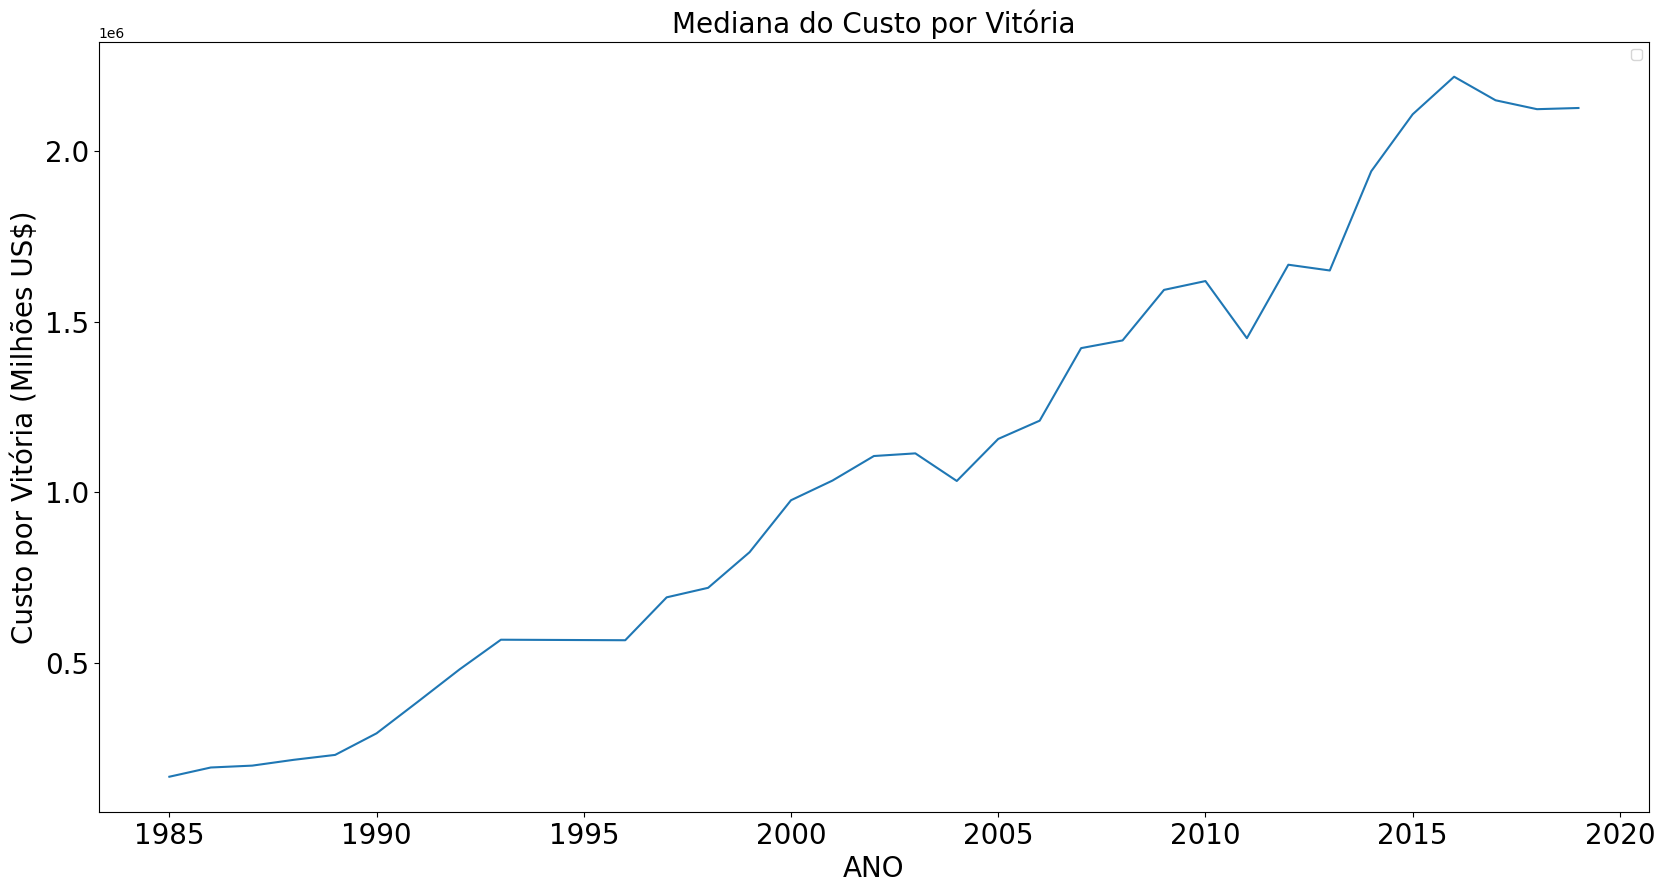

In [164]:
y='custo_vitoria'
x='yearID'
plt.figure(figsize=(20,10))
sns.lineplot(data=df_teams_salary.groupby([x],as_index=False).agg({y:'median'}),x=x,y=y)
plt.title("Mediana do Custo por Vitória",fontsize=20)
plt.legend([])
plt.xlabel('ANO',fontsize=20)
plt.ylabel('Custo por Vitória (Milhões US$)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [75]:
df_teams_salary.groupby(['yearID'],as_index=False).agg({'custo_vitoria':'mean'}).head(50)

yearID  custo_vitoria
0     1985  170361.456487
1     1986  197586.675068
2     1987  188111.854849
3     1988  206199.282184
4     1989  239300.023829
5     1990  294725.048741
6     1991  409908.329224
7     1992  542392.301390
8     1993  570458.339728
9     1996  552995.151690
10    1997  674278.134250
11    1998  715464.680097
12    1999  850843.305372
13    2000  956584.826467
14    2001 1076889.623453
15    2002 1147356.861026
16    2003 1177619.470339
17    2004 1139122.429917
18    2005 1235753.193493
19    2006 1314006.887718
20    2007 1410224.555407
21    2008 1526187.246479
22    2009 1579550.736497
23    2010 1592533.030106
24    2011 1592398.962299
25    2012 1752380.875190
26    2013 1899693.654634
27    2014 1984374.149318
28    2015 2204069.276725
29    2016 2287743.735775
30    2017 2177606.896168
31    2018 2184258.538143
32    2019 2269265.889332

##### Custo por Corrida do Ataque

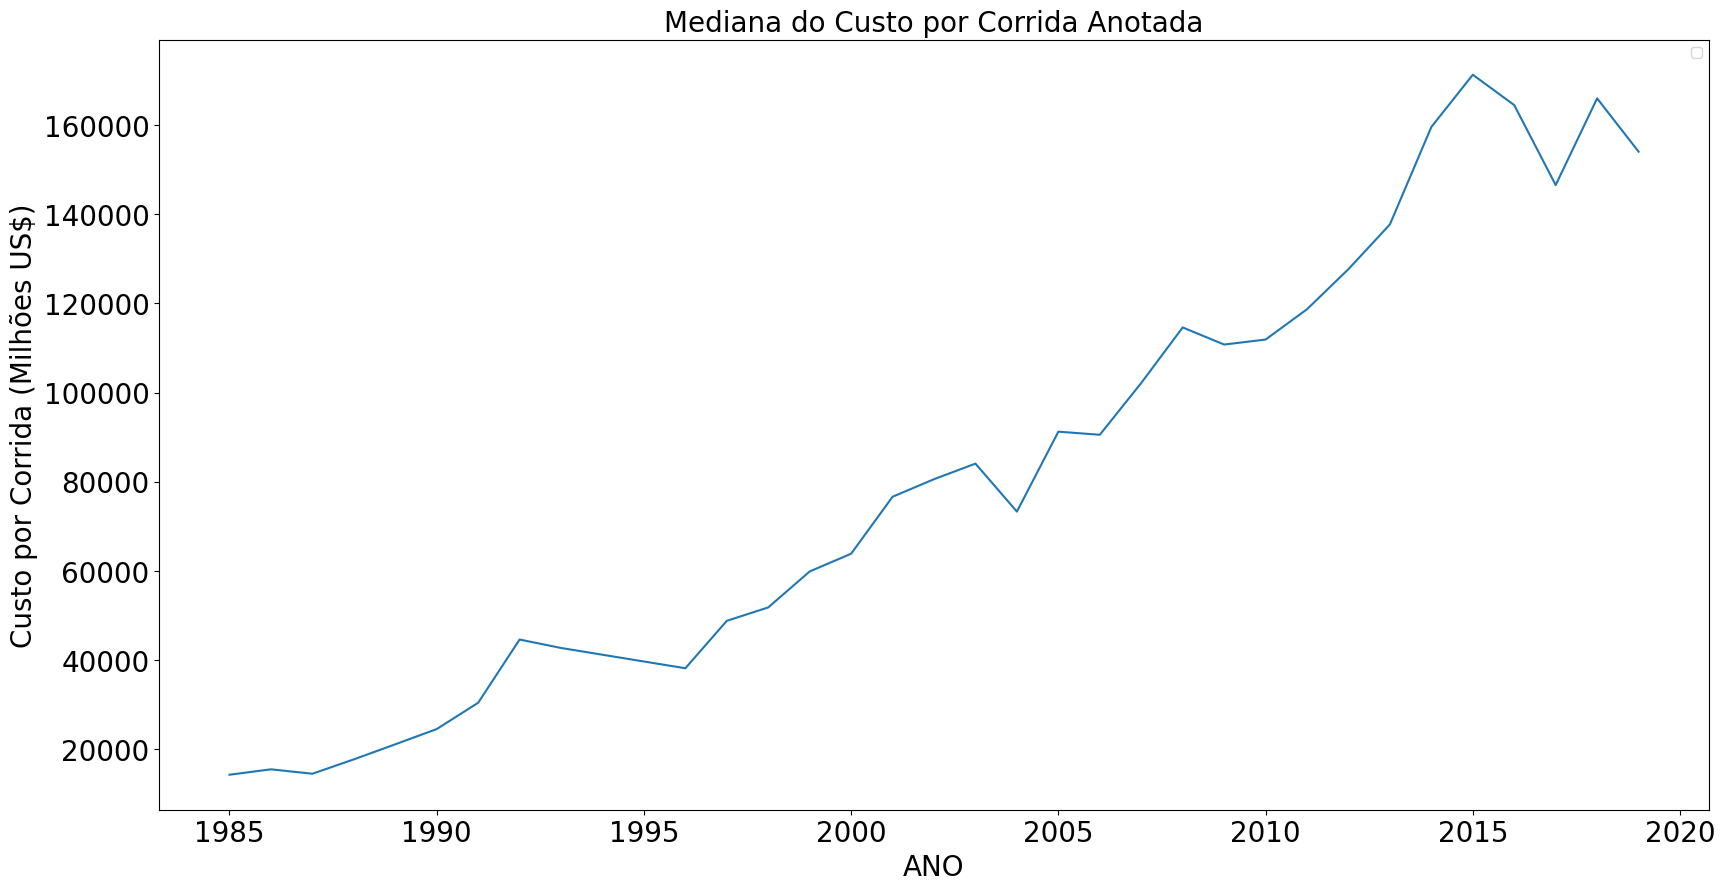

In [167]:
df_teams_salary['custo_corrida'] = df_teams_salary.salary_batting/df_teams_salary.R

y='custo_corrida'
x='yearID'
plt.figure(figsize=(20,10))
sns.lineplot(data=df_teams_salary.groupby([x],as_index=False).agg({y:'median'}),x=x,y=y)
plt.title("Mediana do Custo por Corrida Anotada",fontsize=20)
plt.legend([])
plt.xlabel('ANO',fontsize=20)
plt.ylabel('Custo por Corrida (Milhões US$)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [77]:
df_teams_salary.groupby(['yearID'],as_index=False).agg({'custo_corrida':'mean'}).head(50)

yearID  custo_corrida
0     1985   14016.308462
1     1986   15922.835536
2     1987   14034.807394
3     1988   17542.763056
4     1989   20402.383460
5     1990   24329.459002
6     1991   32880.408163
7     1992   45772.268635
8     1993   42800.884789
9     1996   40267.780166
10    1997   50987.722686
11    1998   52943.277353
12    1999   58410.839893
13    2000   65572.492362
14    2001   80087.512257
15    2002   87082.355489
16    2003   90122.230700
17    2004   84112.849574
18    2005   95256.086296
19    2006   94815.523945
20    2007  103011.021155
21    2008  114826.401045
22    2009  119259.040944
23    2010  125125.307883
24    2011  130406.339699
25    2012  137166.183021
26    2013  156316.107109
27    2014  167960.162664
28    2015  178114.175858
29    2016  176536.444999
30    2017  158168.749817
31    2018  166379.785840
32    2019  150168.193243

### Considerando a temporada de 2019, qual o melhor custo benefício para montar um time titular?

##### Rebatedores

In [78]:
df_batting2019 = df_batting4.loc[(df_batting4.yearID==2019) &
                                 (df_batting4.salary_ajs>0)]

In [79]:
df_batting2019.describe()

yearID          G         AB          R          H         2B  \
count  622.000000 622.000000 622.000000 622.000000 622.000000 622.000000   
mean  2019.000000  64.191318 151.736334  21.344051  38.305466   7.918006   
std      0.000000  45.539143 199.635428  31.329231  54.525976  11.819960   
min   2019.000000   1.000000   0.000000   0.000000   0.000000   0.000000   
25%   2019.000000  28.000000   0.000000   0.000000   0.000000   0.000000   
50%   2019.000000  52.000000  30.000000   2.000000   3.000000   0.000000   
75%   2019.000000  98.750000 292.750000  37.750000  71.750000  14.000000   
max   2019.000000 162.000000 657.000000 135.000000 201.000000  58.000000   

              3B         HR        RBI         SB         CS         BB  \
count 622.000000 622.000000 622.000000 622.000000 622.000000 622.000000   
mean    0.692926   6.263666  20.670418   1.959807   0.707395  14.709003   
std     1.443710  10.308975  30.638231   5.086371   1.609526  22.449669   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   1.000000   0.000000   0.000000   1.000000   
75%     1.000000  10.000000  36.750000   1.000000   1.000000  26.000000   
max    10.000000  49.000000 121.000000  46.000000   9.000000 119.000000   

              SO        IBB        HBP         SH         SF       GIDP  \
count 622.000000 622.000000 622.000000 622.000000 622.000000 622.000000   
mean   37.721865   0.745981   1.699357   0.601286   1.114148   3.260450   
std    47.800594   2.011186   3.058417   1.389586   1.947332   4.910111   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%    13.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%    68.000000   1.000000   2.000000   1.000000   2.000000   6.000000   
max   189.000000  19.000000  25.000000  12.000000  12.000000  23.000000   

             WAR    age_war      salary_war        AVG         PA        OBP  \
count 574.000000 622.000000      622.000000 438.000000 622.000000 440.000000   
mean    0.544077  29.028939  4036532.004823   0.183679 169.860129   0.239557   
std     1.521541   3.457466  5861557.609156   0.125543 223.625128   0.139707   
min    -2.140000  19.000000   100000.000000   0.000000   0.000000   0.000000   
25%    -0.047500  26.000000   567525.000000   0.088889   0.000000   0.147059   
50%     0.000000  29.000000  1300000.000000   0.221871  34.000000   0.289173   
75%     0.530000  31.000000  5018750.000000   0.261084 325.500000   0.330275   
max     8.890000  45.000000 36833333.000000   1.000000 747.000000   1.000000   

              1B         TB        SLG        OPS   R_create  R_create_x_R  \
count 622.000000 622.000000 438.000000 438.000000 440.000000    364.000000   
mean   23.430868  66.400322   0.297712   0.537222  28.231982           inf   
std    33.352664  96.657965   0.198298   0.327423  32.978185           NaN   
min     0.000000   0.000000   0.000000   0.000000   0.000000     -1.000000   
25%     0.000000   0.000000   0.110044   0.259091   0.333333     -0.353536   
50%     2.000000   4.000000   0.353739   0.640800  13.042912     -0.118907   
75%    40.000000 120.750000   0.446234   0.777082  51.255340      0.008676   
max   133.000000 359.000000   1.000000   2.000000 122.263473           inf   

       SB_percentage    R_per_H  R_per_BAP   R_per_SB   birthYear     weight  \
count     209.000000 364.000000 377.000000 349.000000  622.000000 622.000000   
mean        0.678800        inf        inf   0.073590 1989.464630 213.180064   
std         0.295375        NaN        NaN   0.119267    3.457290  20.217968   
min         0.000000   0.000000   0.000000   0.000000 1973.000000 155.000000   
25%         0.500000   1.500000   2.218750   0.000000 1987.000000 200.000000   
50%         0.750000   1.816437   2.591837   0.020833 1990.000000 213.

In [80]:
df_best = pd.DataFrame()
lista_pos = ['C','1B','2B','3B','SS','OF']
for pos in lista_pos:

    if(pos=='OF'):
        salary = df_batting2019.loc[(df_batting2019.POS==pos)].salary_ajs.quantile(0.6)
    elif(pos=='C'):
        salary = df_batting2019.loc[(df_batting2019.POS==pos)].salary_ajs.quantile(0.9)
    else:
        salary = df_batting2019.loc[(df_batting2019.POS==pos)].salary_ajs.quantile(0.5)
        
    df = df_batting2019.loc[(df_batting2019.POS==pos) &
                            (df_batting2019.OBP>0.3) &
                            (df_batting2019.salary_ajs<=salary) &
                            (df_batting2019.salary_ajs>=df_batting2019.loc[(df_batting2019.POS==pos)]\
                                                                      .salary_ajs.quantile(0.1)) &
                            (df_batting2019.seasons_played>5) &
                            (df_batting2019.G>=100)][['name','playerID','POS','G','AB','age','R','H','BB','2B','3B','HR',
                                                      'RBI','SB','SO','BB','IBB','HBP','WAR','AVG','OBP','SLG','OPS',
                                                      'R_create','SB_percentage','bats','seasons_played','IMC',
                                                      'salary_ajs']]
    df2 = df.sort_values('OBP',ascending=False)
    if(pos=='OF'):
        df2 = df2.head(3)
    else:
        df2 = df2.head(1)
        
    df_best = pd.concat([df_best,df2])

In [84]:
df_best[['name','POS','age','OBP','SLG','OPS','BB','salary_ajs']].rename(columns={'name':'NAME','age':'AGE','salary_ajs':'SALARY'})

NAME POS  AGE      OBP      SLG      OPS  BB  BB  \
17354   Robinson Chirinos   C   35 0.345538 0.442623 0.788161  51  51   
103646   Christian Walker  1B   28 0.348259 0.476371 0.824629  67  67   
878        Hanser Alberto  2B   26 0.327273 0.421756 0.749028  16  16   
88097         Miguel Sano  3B   26 0.346241 0.576316 0.922557  55  55   
47689       Jose Iglesias  SS   29 0.316981 0.406746 0.723727  20  20   
50846          Matt Joyce  OF   34 0.407563 0.450000 0.857563  38  38   
14829          Mark Canha  OF   30 0.396378 0.517073 0.913451  67  67   
38768     Robbie Grossman  OF   29 0.334025 0.347619 0.681644  59  59   

               SALARY  
17354  5750000.000000  
103646  559800.000000  
878     578000.000000  
88097  2650000.000000  
47689  2500000.000000  
50846  1250000.000000  
14829  2050000.000000  
38768  2000000.000000

In [172]:
print('Projeções do time (Rebatedores):\n')
print('Salário Total: US$',df_best.salary_ajs.sum())
print('Salário Médio: US$',df_best.salary_ajs.mean())
print('Salário médio com rebatedores na liga em 2019: US$',round(df_teams_salary.loc[(df_teams_salary.yearID==2019)]\
                                                                                .salary_batting.mean(),2))
print('OBP:',round(df_best.OBP.mean(),3))
print('SLG:',round(df_best.SLG.mean(),3))
print('Projeção de Corridas Anotadas (OBP*5340.639-1023.062):',int(round((df_best.OBP.mean()*5340.639)-1023.062,0)))
print('Projeção de Corridas Anotadas (SLG*2465.618-270.7146):',int(round((df_best.SLG.mean()*2465.618)-270.7146,0)))
print('Número de Vitórias considerando 700 corridas sofridas e média de OBP:',
      int(round((((df_best.OBP.mean()*5340.639)-1023.062)-700)*0.1015+80.951,0)))
print('Número de Vitórias considerando 700 corridas sofridas e média de SLG:',
      int(round((((df_best.SLG.mean()*2465.618)-270.7146)-700)*0.1015+80.951,0)))
print('Custo por corrida: US$',round(df_best.salary_ajs.sum()/int(round((df_best.OBP.mean()*5340.639)-1023.062,0)),2))
print('Custo médio por corrida da liga em 2019: US$',round(df_teams_salary.loc[(df_teams_salary.yearID==2019)]\
      .groupby(['yearID'],as_index=False).agg({'custo_corrida':'mean'}).custo_corrida[0],2))

Projeções do time (Rebatedores):

Salário Total: US$ 17337800.0
Salário Médio: US$ 2167225.0
Salário médio com rebatedores na liga em 2019: US$ 118162774.05
OBP: 0.353
SLG: 0.455
Projeção de Corridas Anotadas (OBP*5340.639-1023.062): 861
Projeção de Corridas Anotadas (SLG*2465.618-270.7146): 851
Número de Vitórias considerando 700 corridas sofridas e média de OBP: 97
Número de Vitórias considerando 700 corridas sofridas e média de SLG: 96
Custo por corrida: US$ 20136.82
Custo médio por corrida da liga em 2019: US$ 150168.19


##### Arremessadores

In [87]:
df_pitching2019 = df_pitching4.loc[(df_pitching4.yearID==2019) &
                                   (df_pitching4.salary_ajs>0)]

In [88]:
df_best_pitcher = pd.DataFrame()
lista_pos_pitcher = ['SP','RP']
for pos in lista_pos_pitcher:

    if(pos=='SP'): ### Starters
        salary = df_pitching2019.loc[(df_pitching2019.pitcher_type==pos)].salary_ajs.quantile(0.7)
        df = df_pitching2019.loc[(df_pitching2019.pitcher_type==pos) &
                                 (df_pitching2019.ERA<4) &
                                 (df_pitching2019.salary_ajs<=salary) &
                                 (df_pitching2019.salary_ajs>=df_pitching2019.loc[(df_pitching2019.pitcher_type==pos)]\
                                                                             .salary_ajs.quantile(0.1)) &
                                (df_pitching2019.seasons_played>5) &
                                (df_pitching2019.G>=15)][['name','playerID','age','pitcher_type','G','W','L','ERA','ER','BAOpp',
                                                          'H','BB','IBB','HBP','HR','SHO','WAR','SV','seasons_played',
                                                          'throws','salary_ajs']]
    
    else: ### Relivers
        salary = df_pitching2019.loc[(df_pitching2019.pitcher_type==pos)].salary_ajs.quantile(0.6)
        df = df_pitching2019.loc[(df_pitching2019.pitcher_type==pos) &
                                 (df_pitching2019.ERA<4) &
                                 (df_pitching2019.salary_ajs<=salary) &
                                 (df_pitching2019.salary_ajs>=df_pitching2019.loc[(df_pitching2019.pitcher_type==pos)]\
                                                                             .salary_ajs.quantile(0.1)) &
                                (df_pitching2019.seasons_played>5) &
                                (df_pitching2019.G>=20)][['name','playerID','age','pitcher_type','G','W','L','ERA','ER','BAOpp',
                                                          'H','BB','IBB','HBP','HR','SHO','WAR','SV','seasons_played',
                                                          'throws','salary_ajs']]
        
        
    df2 = df.sort_values('ERA',ascending=True)
    if(pos=='SP'):
        df2 = df2.head(5)
    else:
        df2 = df2.head(6)
        
    df_best_pitcher = pd.concat([df_best_pitcher,df2])

In [89]:
df_best_pitcher[['name','age','pitcher_type','ERA','BAOpp','salary_ajs']].rename(columns={'name':'NAME','age':'AGE',
                                                                                         'pitcher_type':'POS','salary_ajs':'SALARY'})

NAME  AGE POS      ERA    BAOpp         SALARY
39741     Marcus Stroman   28  SP 3.365000 0.262500 7400000.000000
14829       Gio Gonzalez   33  SP 3.500000 0.234000 2000000.000000
2132       Chris Bassitt   30  SP 3.810000 0.229000  565000.000000
34910  Eduardo Rodriguez   26  SP 3.810000 0.253000 4300000.000000
15213           Jon Gray   27  SP 3.840000 0.259000 2935000.000000
44912    Brandon Workman   30  RP 1.880000 0.123000 1150000.000000
25902         Trevor May   29  RP 2.940000 0.184000  900000.000000
12004        Buck Farmer   28  RP 3.720000 0.247000  570800.000000
41186        Josh Tomlin   34  RP 3.740000 0.267000 1250000.000000
19579       Luke Jackson   27  RP 3.840000 0.266000  585000.000000
28326        Adam Morgan   29  RP 3.940000 0.187000 1100000.000000

In [91]:
print('Projeções do time (Arremessadores):\n')
print('Salário Total: US$',round(df_best_pitcher.salary_ajs.sum(),2))
print('Salário Médio: US$',round(df_best_pitcher.salary_ajs.mean(),2))
print('Salário médio com arremessadores na liga em 2019: US$',round(df_teams_salary.loc[(df_teams_salary.yearID==2019)]\
                                                                                   .salary_pitcher.mean(),2))
print('ERA:',round(df_best_pitcher.ERA.mean(),3))
print('BAOpp:',round(df_best_pitcher.BAOpp.mean(),3))
print('Projeção de Corridas Cedidas (ERA*155.235+21.989):',int(round((df_best_pitcher.ERA.mean()*155.235)-21.989,0)))

Projeções do time (Arremessadores):

Salário Total: US$ 22755800.0
Salário Médio: US$ 2068709.09
Salário médio com arremessadores na liga em 2019: US$ 56765211.47
ERA: 3.49
BAOpp: 0.228
Projeção de Corridas Cedidas (ERA*155.235+21.989): 520


#### Totais do time proposto

In [90]:
print('Salário total: US$',round(df_best.salary_ajs.sum()+df_best_pitcher.salary_ajs.sum(),2))
print('Salário total médio da liga em 2019: US$',round(df_teams_salary.loc[(df_teams_salary.yearID==2019)]\
                                                                                           .salary_total.mean(),2))
print('Número de Vitórias considerando corridas sofridas e média de OBP:',
      int(round((((df_best.OBP.mean()*5340.639)-1023.062)-(df_best_pitcher.ERA.mean()*155.235)-21.989)*0.1015+80.951,0)),'W')
print('Total médio de vitórias dos times que terminaram em 1° lugar na divisão:',
      round(df_teams_salary.loc[(df_teams_salary.yearID==2019) & (df_teams_salary.Rank==1)].W.mean(),0),'W')
print('Máximo de vitórias em 2019:',
      round(df_teams_salary.loc[(df_teams_salary.yearID==2019)].W.max(),0),'W')

Salário total: US$ 40093600.0
Salário total médio da liga em 2019: US$ 174927985.53
Número de Vitórias considerando corridas sofridas e média de OBP: 111 W
Total médio de vitórias dos times que terminaram em 1° lugar na divisão: 102.0 W
Máximo de vitórias em 2019: 107 W
